<a href="https://colab.research.google.com/github/jephefnie/Covid-19_Prediction/blob/master/COVID_19_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
# import os
import numpy as np
import pandas as pd
# from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
# from sklearn.svm import SVR
# from statsmodels.tsa.api import  Holt

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
url = 'https://raw.githubusercontent.com/xylieong/daily_covid19_predictions/master/WHO-COVID-19-global-data.csv' 

df1 = pd.read_csv(url)
print(df1)

      Date_reported  Country_code  ...  New_deaths  Cumulative_deaths
0        2020-02-24            AF  ...           0                  0
1        2020-02-25            AF  ...           0                  0
2        2020-02-26            AF  ...           0                  0
3        2020-02-27            AF  ...           0                  0
4        2020-02-28            AF  ...           0                  0
...             ...           ...  ...         ...                ...
28737    2020-07-12            ZW  ...           5                 18
28738    2020-07-13            ZW  ...           0                 18
28739    2020-07-14            ZW  ...           1                 19
28740    2020-07-15            ZW  ...           1                 20
28741    2020-07-16            ZW  ...           0                 20

[28742 rows x 8 columns]


In [ ]:
df1.columns

Index(['Date_reported', ' Country_code', ' Country', ' WHO_region',
       ' New_cases', ' Cumulative_cases', ' New_deaths', ' Cumulative_deaths'],
      dtype='object')

In [ ]:
# df1['Country'] = [df1.get('Country','') for data in df1]
df_malaysia = df1.loc[df1[' Country'] == 'Malaysia']

# print(df_malaysia.head())
# print(df_malaysia.tail()) 
print(df_malaysia)

      Date_reported  Country_code  ...  New_deaths  Cumulative_deaths
15992    2020-01-25            MY  ...           0                  0
15993    2020-01-26            MY  ...           0                  0
15994    2020-01-27            MY  ...           0                  0
15995    2020-01-28            MY  ...           0                  0
15996    2020-01-29            MY  ...           0                  0
...             ...           ...  ...         ...                ...
16162    2020-07-13            MY  ...           0                122
16163    2020-07-14            MY  ...           0                122
16164    2020-07-15            MY  ...           0                122
16165    2020-07-16            MY  ...           0                122
16166    2020-07-17            MY  ...           0                122

[175 rows x 8 columns]


In [ ]:
#check if there is missing value
df_malaysia.isnull().sum().sum()

0

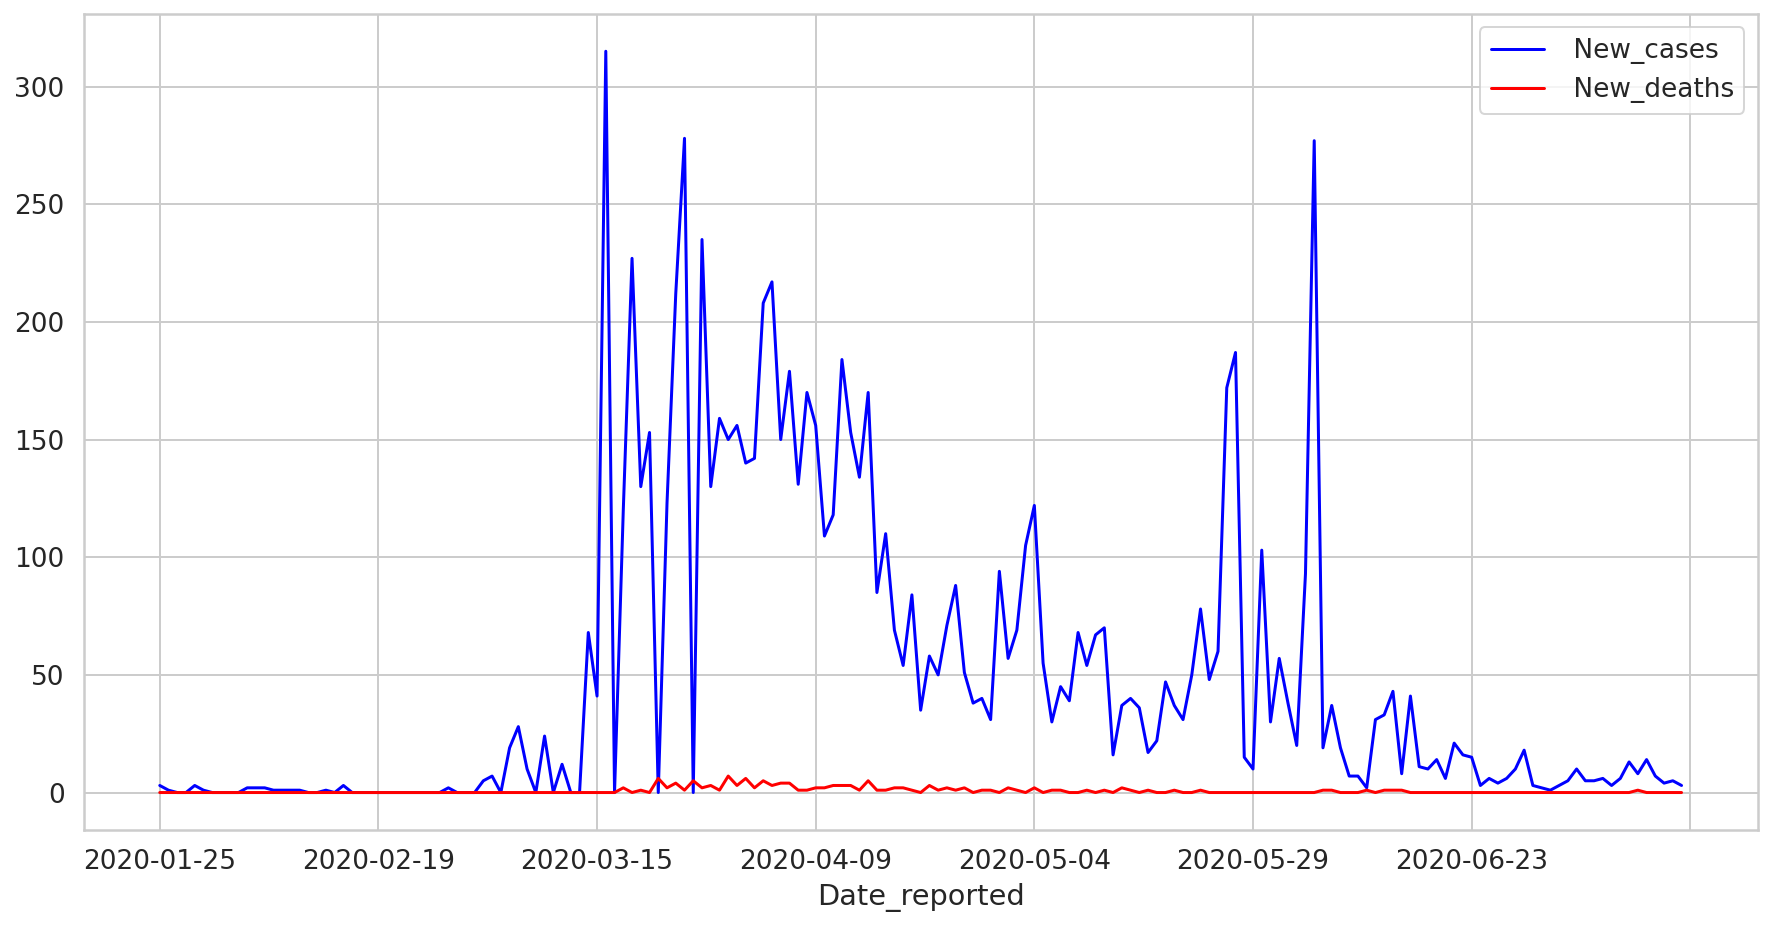

In [ ]:
# plt.rcParams["figure.figsize"]=10,5 
# df_malaysia.plot(x = 'Date', y = 'Confirmed', color = 'blue')

# ax1 = plt.gca()
# df_malaysia.plot(x = 'Date', y = 'Deaths', color = 'red', ax = ax1)
# plt.show()

plt.rcParams["figure.figsize"] = 15, 7.5
df_malaysia.plot(x = 'Date_reported', y = ' New_cases', color = 'blue')

ax1 = plt.gca()
df_malaysia.plot(x = 'Date_reported', y = ' New_deaths', color = 'red', ax = ax1)
plt.show()

In [ ]:
# See how many days we have
df_malaysia.shape[0]

175

In [ ]:
df_new = df_malaysia.iloc[:, [0, 4]]
df_new

,Date_reported,New_cases
15992,2020-01-25,3
15993,2020-01-26,1
15994,2020-01-27,0
15995,2020-01-28,0
15996,2020-01-29,3
...,...,...
16162,2020-07-13,14
16163,2020-07-14,7
16164,2020-07-15,4
16165,2020-07-16,5


In [ ]:
df_death = df_malaysia.iloc[:, [0, 6]]
df_death

,Date_reported,New_deaths
15992,2020-01-25,0
15993,2020-01-26,0
15994,2020-01-27,0
15995,2020-01-28,0
15996,2020-01-29,0
...,...,...
16162,2020-07-13,0
16163,2020-07-14,0
16164,2020-07-15,0
16165,2020-07-16,0


In [ ]:
data_size = df_malaysia.shape[0]
test_data_size = int(data_size * 0.20) # Use 25% per test and 80% for train

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# New case train & test data
Ntrain_data = df_new[:-test_data_size]
Ntest_data = df_new[-test_data_size:]

# Death case train & test data
Dtrain_data = df_death[:-test_data_size]
Dtest_data = df_death[-test_data_size:]

print('Train data size: ' + str(Ntrain_data.shape[0]))
print('Test data size: ' + str(Ntest_data.shape[0]))

Train data size: 140
Test data size: 35


LSTM - New case

**Increase** training speed and performance of the model

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(Ntrain_data.iloc[:, 1], axis = 1))

Ntrain_data = scaler.transform(np.expand_dims(Ntrain_data.iloc[:, 1], axis = 1))
Ntest_data = scaler.transform(np.expand_dims(Ntest_data.iloc[:, 1], axis = 1))

In [ ]:
# Ntest_data

In [ ]:
# scaler.inverse_transform(Ntest_data)

Convert into smaller sequence of daily cases

In [ ]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


In [ ]:
seq_length = 30
X_train, y_train = create_sequences(Ntrain_data, seq_length)
X_test, y_test = create_sequences(Ntest_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [ ]:
class CoronaVirusPredictor(nn.Module):
  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()
    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers
    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.50
    )
    self.linear = nn.Linear(in_features=n_hidden, out_features=1)
  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )
  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [ ]:
def train_model(
  model,
  train_data,
  train_labels,
  test_data=None,
  test_labels=None
):
  loss_fn = torch.nn.MSELoss(reduction='sum')

  optimiser = torch.optim.Adamax(model.parameters(), lr=1e-3)
  num_epochs = 150
  # batch_size=32
  momentum = 0.1
  learn_rate = 0.001
  #weight_constraint=1

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

  return model.eval(), train_hist, test_hist

In [ ]:
model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)

model, train_hist, test_hist = train_model(
  model,
  X_train,
  y_train,
  X_test,
  y_test
)

Epoch 0 train loss: 11.273306846618652 test loss: 0.0008243885822594166
Epoch 10 train loss: 5.841690540313721 test loss: 0.135158509016037
Epoch 20 train loss: 5.751053333282471 test loss: 0.22121687233448029
Epoch 30 train loss: 5.744460105895996 test loss: 0.1749173402786255
Epoch 40 train loss: 5.707597255706787 test loss: 0.1987428367137909
Epoch 50 train loss: 5.730758190155029 test loss: 0.18965208530426025
Epoch 60 train loss: 5.686800003051758 test loss: 0.202443927526474
Epoch 70 train loss: 5.764572620391846 test loss: 0.20084622502326965
Epoch 80 train loss: 5.6996169090271 test loss: 0.19931605458259583
Epoch 90 train loss: 5.731342792510986 test loss: 0.20057712495326996
Epoch 100 train loss: 5.743557929992676 test loss: 0.2057584822177887
Epoch 110 train loss: 5.740849018096924 test loss: 0.20158115029335022
Epoch 120 train loss: 5.701942443847656 test loss: 0.20473071932792664
Epoch 130 train loss: 5.711925029754639 test loss: 0.2141878306865692
Epoch 140 train loss: 5.

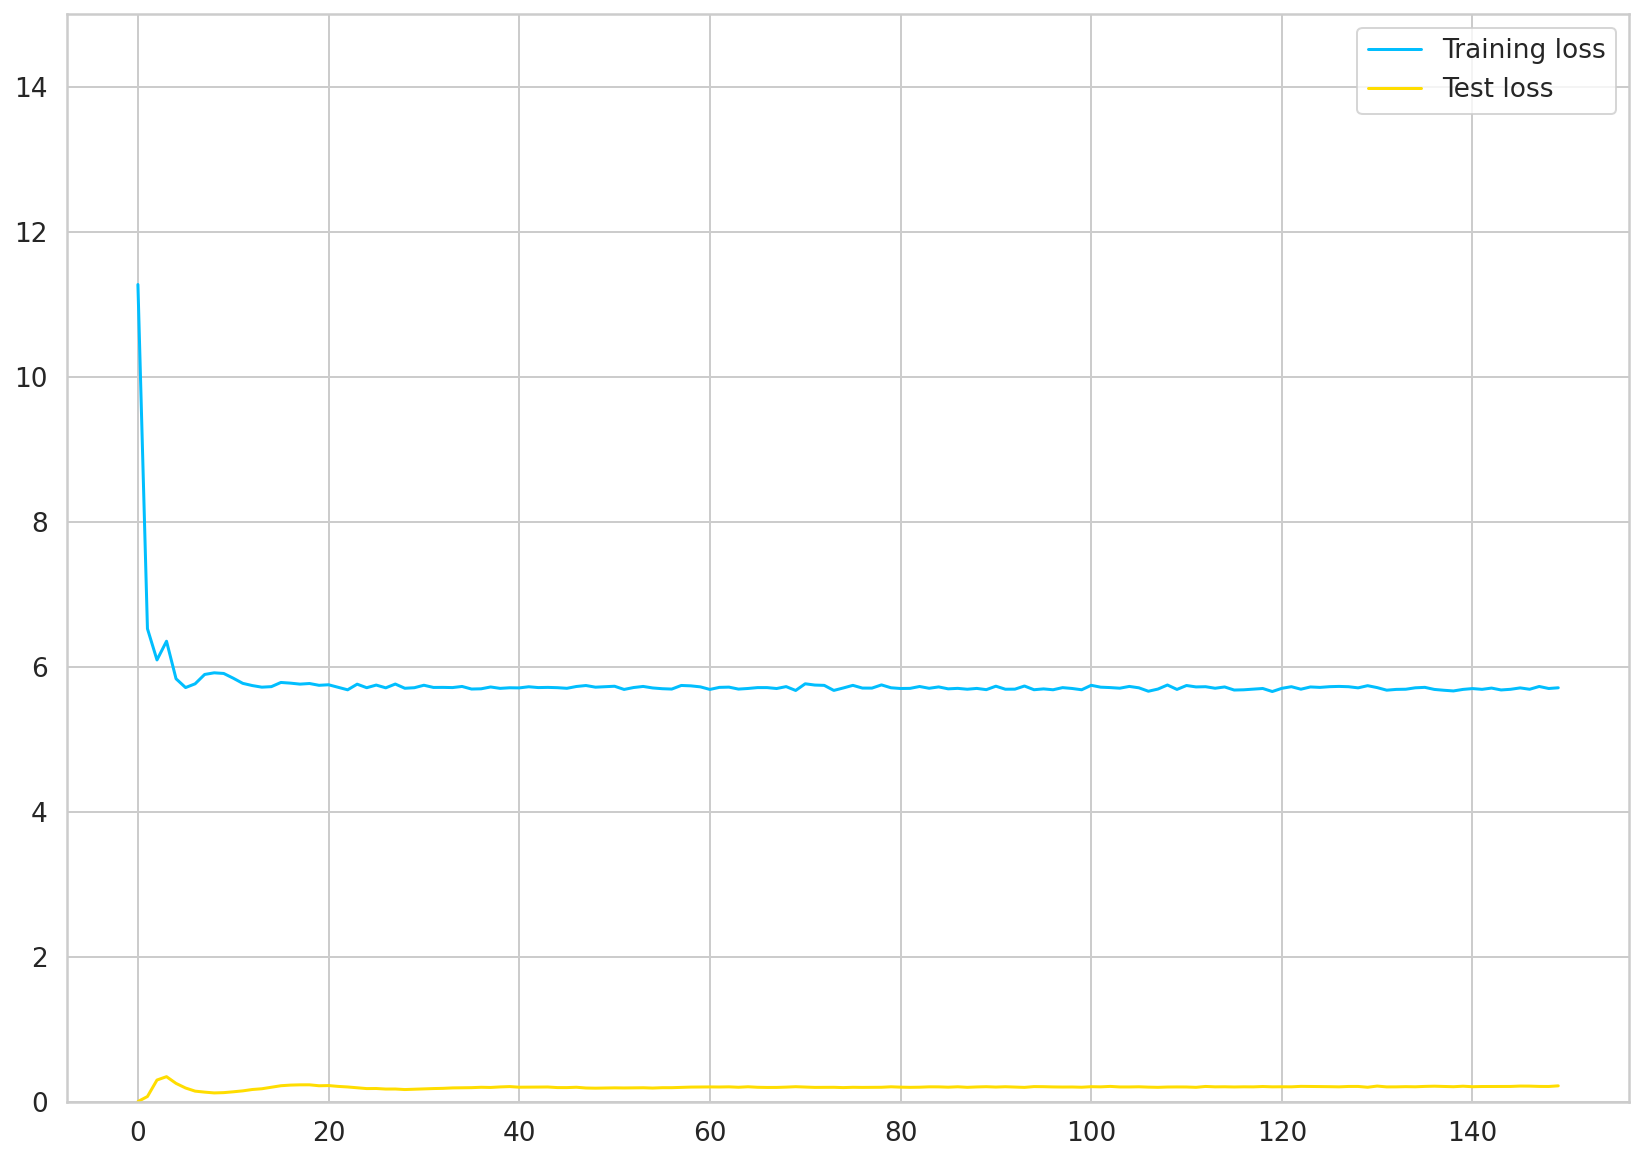

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0, 15))
plt.legend();

Prediction

In [ ]:
with torch.no_grad():
  test_seq = X_test[:1]
  preds = []
  for _ in range(len(X_test)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
preds

[0.25174903869628906,
 0.2497408539056778,
 0.24619324505329132,
 0.24279093742370605]

In [ ]:
y_test

tensor([[0.0444],
        [0.0222],
        [0.0127],
        [0.0159]])

In [ ]:
true_cases = scaler.inverse_transform(
    np.expand_dims(y_test.flatten().numpy(), axis=0)
).flatten()
predicted_cases = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
predicted_cases

array([79.30094719, 78.66836898, 77.55087219, 76.47914529])

In [ ]:
true_cases

array([14.       ,  7.       ,  4.       ,  5.0000005], dtype=float32)

In [ ]:
# Ntest_data

In [ ]:
pc = []
gap = len(Ntest_data) / len(predicted_cases)

for i in range(len(predicted_cases)):
  for j in range(int(gap)):
    pc.append(predicted_cases[i])

if len(pc) < len(Ntest_data):
  diff = len(Ntest_data) - len(pc)
  for i in range(diff):
    pc.append(predicted_cases[len(predicted_cases)-1])

# len(predicted_cases)
len(pc)

35

In [ ]:
# Ntest_data

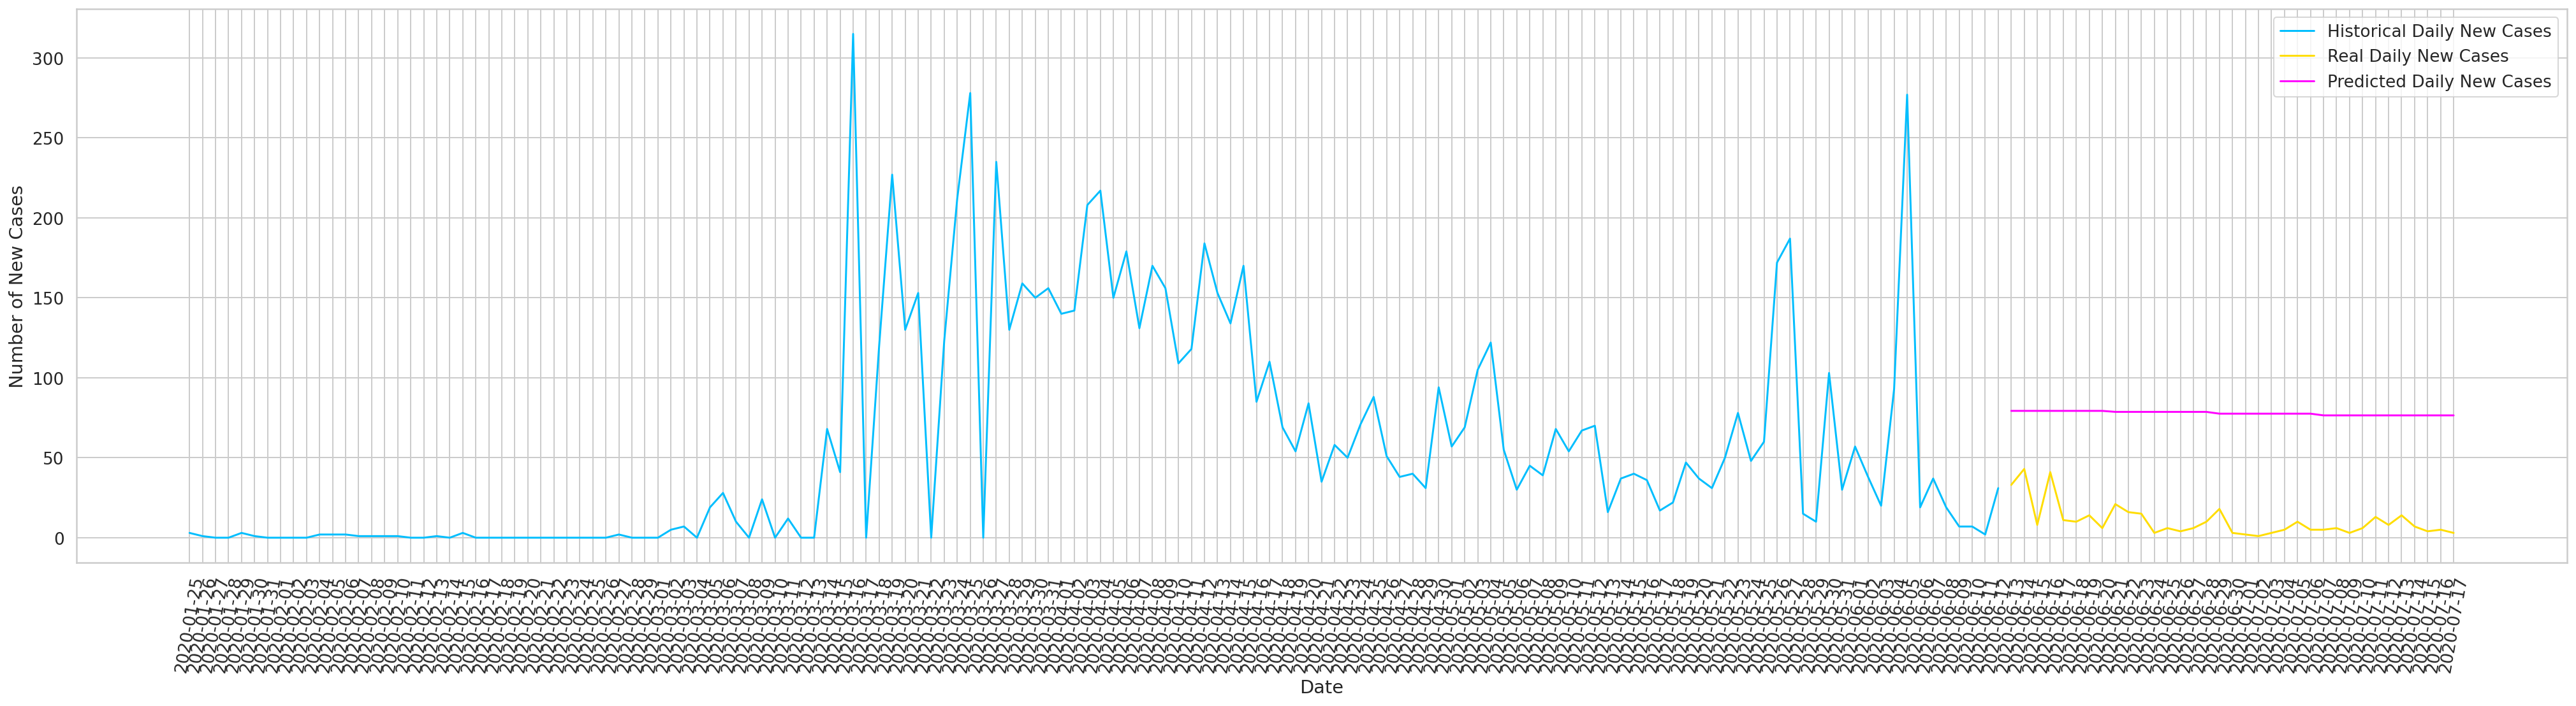

In [ ]:
# from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)

plt.rcParams["figure.figsize"] = 35, 8
# plt.rcParams['axes.labelpad'] = 20.0
# plt.rcParams['xtick.major.pad']='20'
# plt.axes.Axes.tick_params(width = 20)
# ax = plt.gca()
# ax.tick_params(width=5)
# ax.xaxis.set_tick_params(width=20)

# fig, ax = plt.subplots()
# ax.plot(
#   df_new.iloc[: len(Ntrain_data), 0],
#   scaler.inverse_transform(Ntrain_data).flatten(),
#   label='Historical Daily New Cases')

plt.plot(  
  df_new.iloc[: len(Ntrain_data), 0],
  scaler.inverse_transform(Ntrain_data).flatten(),
  label='Historical Daily New Cases'
)

plt.plot(
  df_new.iloc[len(Ntrain_data):len(Ntrain_data) + len(Ntest_data), 0],
  df_new.iloc[len(Ntrain_data):len(Ntrain_data) + len(Ntest_data), 1],
  # true_cases,
  label='Real Daily New Cases'
)
plt.plot(
  df_new.iloc[len(Ntrain_data):len(Ntrain_data) + len(pc), 0],
  # predicted_cases,
  pc,
  label='Predicted Daily New Cases',
  color='Magenta'
)

# # Make a plot with major ticks that are multiples of 20 and minor ticks that
# # are multiples of 5.  Label major ticks with '%d' formatting but don't label
# # minor ticks.
# ax.xaxis.set_major_locator(MultipleLocator(20))
# ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# # For the minor ticks, use no labels; default NullFormatter.
# ax.xaxis.set_minor_locator(MultipleLocator(5))

plt.xlabel('Date')
plt.ylabel('Number of New Cases')
plt.xticks(rotation=80)
plt.legend()

LSTM - Death case

In [ ]:
scaler2 = MinMaxScaler()
scaler2 = scaler2.fit(np.expand_dims(Dtrain_data.iloc[:, 1], axis = 1))

Dtrain_data = scaler2.transform(np.expand_dims(Dtrain_data.iloc[:, 1], axis = 1))
Dtest_data = scaler2.transform(np.expand_dims(Dtest_data.iloc[:, 1], axis = 1))

In [ ]:
#seq_length = 20
X_train2, y_train2 = create_sequences(Dtrain_data, seq_length)
X_test2, y_test2 = create_sequences(Dtest_data, seq_length)
X_train2 = torch.from_numpy(X_train2).float()
y_train2 = torch.from_numpy(y_train2).float()
X_test2 = torch.from_numpy(X_test2).float()
y_test2 = torch.from_numpy(y_test2).float()

In [ ]:
model2 = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)
model2, train_hist2, test_hist2 = train_model(
  model2,
  X_train2,
  y_train2,
  X_test2,
  y_test2
)

Epoch 0 train loss: 10.795194625854492 test loss: 0.0006726037827320397
Epoch 10 train loss: 5.849730014801025 test loss: 0.1321049928665161
Epoch 20 train loss: 5.762503623962402 test loss: 0.22024500370025635
Epoch 30 train loss: 5.729625701904297 test loss: 0.17335380613803864
Epoch 40 train loss: 5.691847801208496 test loss: 0.2046629786491394
Epoch 50 train loss: 5.691273212432861 test loss: 0.1857779324054718
Epoch 60 train loss: 5.6905622482299805 test loss: 0.20081762969493866
Epoch 70 train loss: 5.710779190063477 test loss: 0.1996917873620987
Epoch 80 train loss: 5.709109783172607 test loss: 0.20036056637763977
Epoch 90 train loss: 5.693380355834961 test loss: 0.20873594284057617
Epoch 100 train loss: 5.686410903930664 test loss: 0.19261866807937622
Epoch 110 train loss: 5.690577030181885 test loss: 0.20391352474689484
Epoch 120 train loss: 5.708104133605957 test loss: 0.21295754611492157
Epoch 130 train loss: 5.6994099617004395 test loss: 0.21233496069908142
Epoch 140 train 

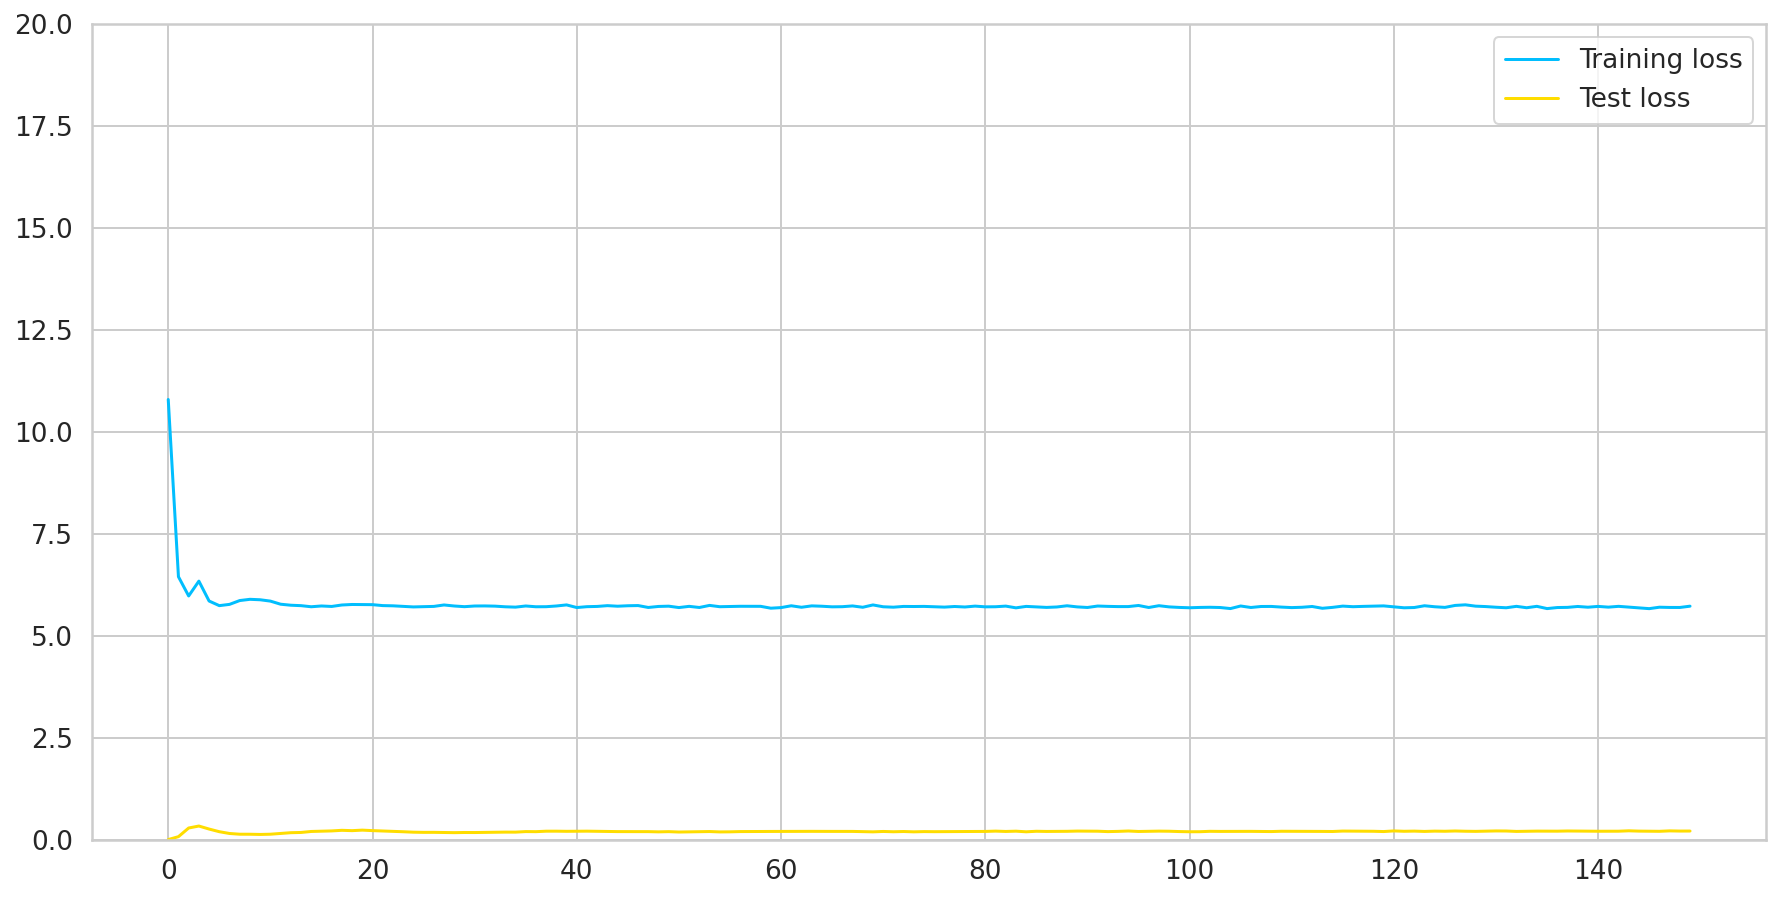

In [ ]:
plt.rcParams["figure.figsize"] = 15, 7.5

plt.plot(train_hist2, label="Training loss")
plt.plot(test_hist2, label="Test loss")
plt.ylim((0, 20))
plt.legend();

In [ ]:
with torch.no_grad():
  test_seq = X_test2[:1]
  preds = []
  for _ in range(len(X_test2)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
true_cases2 = scaler2.inverse_transform(
    np.expand_dims(y_test2.flatten().numpy(), axis=0)
).flatten()
predicted_cases2 = scaler2.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
preds

[0.23993946611881256,
 0.2405189722776413,
 0.24037766456604004,
 0.239911288022995]

In [ ]:
pc2 = []
gap = len(Dtest_data) / len(predicted_cases2)

for i in range(len(predicted_cases2)):
  for j in range(int(gap)):
    pc2.append(predicted_cases2[i])

if len(pc2) < len(Dtest_data):
  diff = len(Dtest_data) - len(pc2)
  for i in range(diff):
    pc2.append(predicted_cases2[len(predicted_cases2)-1])

# len(predicted_cases)
len(pc2)

35

In [ ]:
# pc2

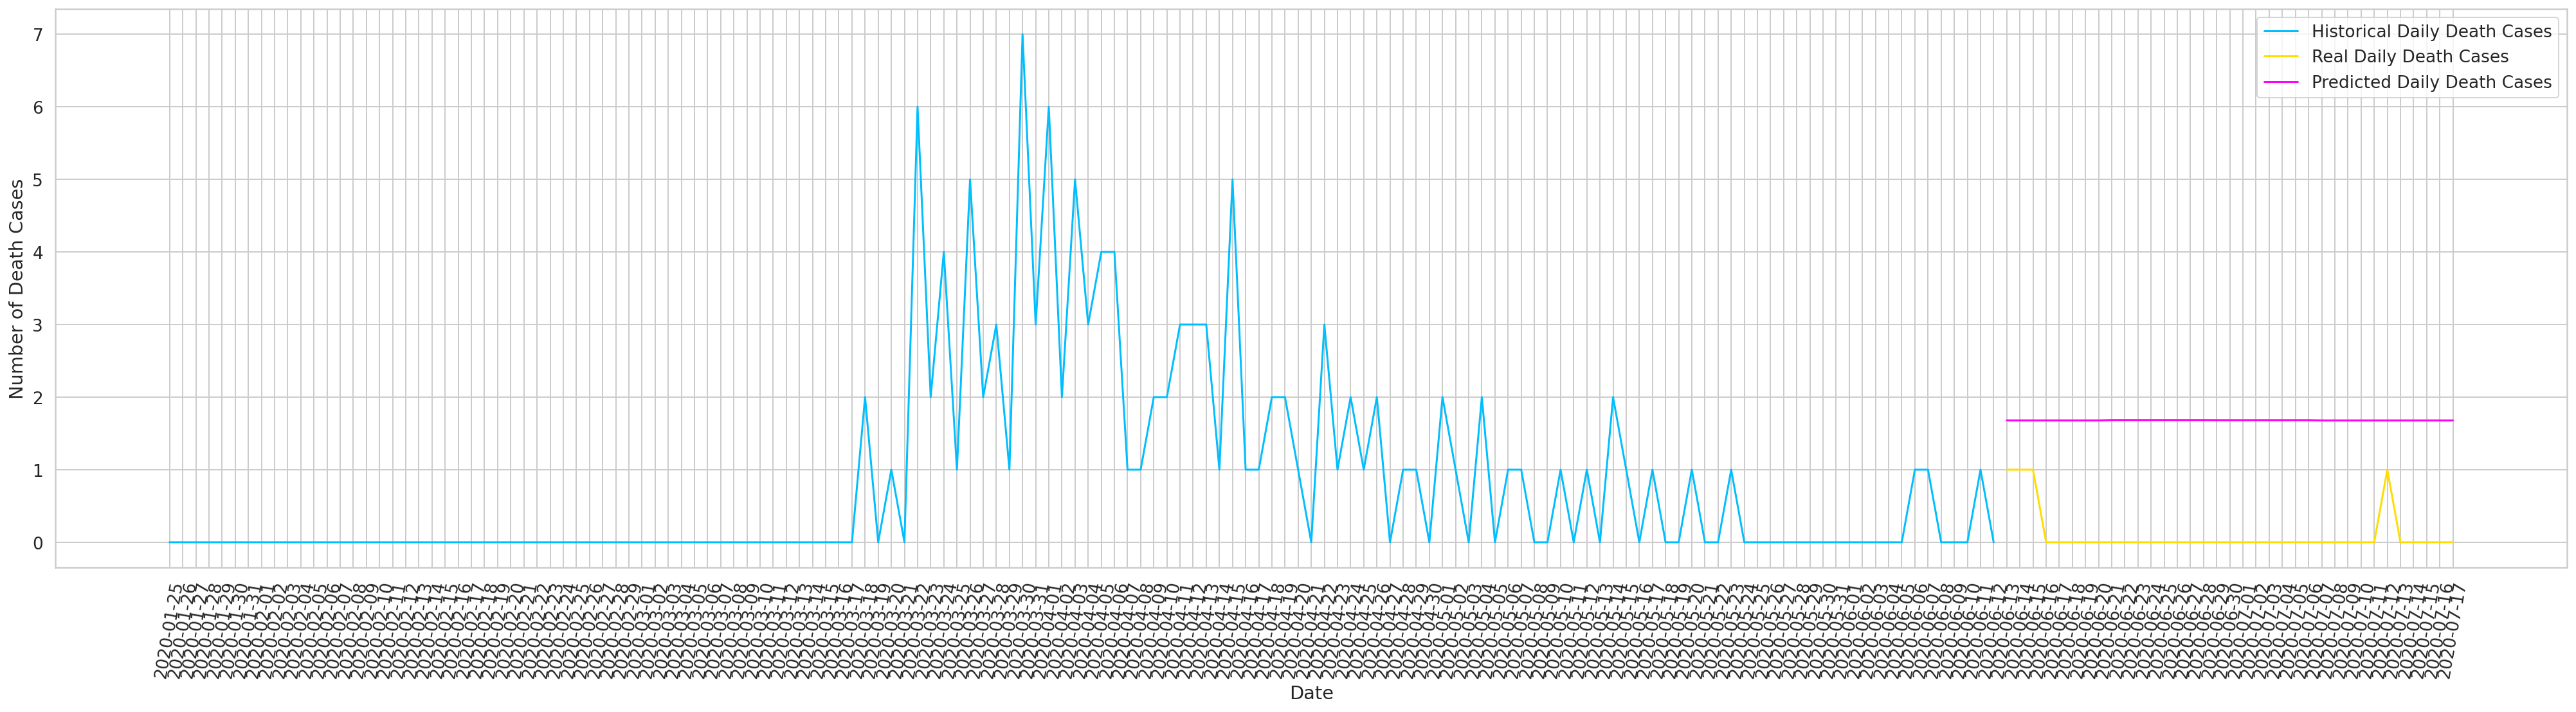

In [ ]:
plt.rcParams["figure.figsize"] = 35, 8

plt.plot(  
  df_death.iloc[: len(Dtrain_data), 0],
  scaler.inverse_transform(Dtrain_data).flatten(),
  label='Historical Daily Death Cases'
  
)
plt.plot(
  df_death.iloc[len(Dtrain_data):len(Dtrain_data) + len(Dtest_data), 0],
  df_death.iloc[len(Dtrain_data):len(Dtrain_data) + len(Dtest_data), 1],
  # true_cases2,
  label='Real Daily Death Cases'
)
plt.plot(
  df_death.iloc[len(Dtrain_data):len(Dtrain_data) + len(pc2), 0],
  pc2,
  label='Predicted Daily Death Cases',
  color='magenta'
)
plt.xlabel('Date')
plt.ylabel('Number of Death Cases')
plt.xticks(rotation=80)
plt.legend()


Test Accuracy

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(true_cases, predicted_cases))

print("The RMSE value of new case prediction is =",rmse)  #if less than 180 means ok

The RMSE value of new case prediction is = 70.56834941971708


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(true_cases2, predicted_cases2))

print("The RMSE value of death case prediction is =",rmse)  #if less than 180 means ok

The RMSE value of death case prediction is = 1.6824891407206997


Use all data to be inputed into the model to preduct future NEW case

In [ ]:
# Add rows for future predictions
future_day = 50

idx = list(df_new.index)
new_rows = list(map(str, range(4, 4 + future_day)))  # easier extensible than new_rows = ["4", "5"]
idx.extend(new_rows)
df_Fnew = df_new.reindex(index=idx)

In [ ]:
df_Fnew = df_Fnew.reset_index()

In [ ]:
df_Fnew = df_Fnew.iloc[:, [1, 2]]

In [ ]:
df_Fnew

,Date_reported,New_cases
0,2020-01-25,3
1,2020-01-26,1
2,2020-01-27,0
3,2020-01-28,0
4,2020-01-29,3
...,...,...
220,NaN,nan
221,NaN,nan
222,NaN,nan
223,NaN,nan


In [ ]:
from datetime import timedelta as td
import datetime
import math

dur = td(days = 1)

for n in range(len(df_Fnew) - len(df_new)):
  # if math.isnan(df_Fnew.at[n + len(df_new), 'Date_reported']):
    tempDateTime = pd.to_datetime(df_Fnew.at[n + len(df_new) - 1, 'Date_reported']) + dur
    df_Fnew.at[n + len(df_new), 'Date_reported'] = datetime.datetime.strftime(tempDateTime,'%Y-%m-%d')

In [ ]:
df_Fnew

,Date_reported,New_cases
0,2020-01-25,3
1,2020-01-26,1
2,2020-01-27,0
3,2020-01-28,0
4,2020-01-29,3
...,...,...
220,2020-09-01,nan
221,2020-09-02,nan
222,2020-09-03,nan
223,2020-09-04,nan


In [ ]:
# data_size = df_malaysia.shape[0]
# test_data_size = int(data_size * 0.20) # Use 25% per test and 80% for train

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# New case train & test data
FNtrain_data = df_new
FNtest_data = df_Fnew[len(df_new):]

# Death case train & test data
FDtrain_data = df_death
# FDtest_data = df_death[-test_data_size:]

# print('Train data size: ' + str(Dtrain_data.shape[0]))
# print('Test data size: ' + str(Dtest_data.shape[0]))

In [ ]:
# FNtest_data

In [ ]:
# scaler = MinMaxScaler()

# scaler = scaler.fit(np.expand_dims(df_new, axis=1))

# all_new_data = scaler.transform(np.expand_dims(df_new, axis=1))

# all_new_data.shape

scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(FNtrain_data.iloc[:, 1], axis = 1))

FNtrain_data = scaler.transform(np.expand_dims(FNtrain_data.iloc[:, 1], axis = 1))
FNtest_data = scaler.transform(np.expand_dims(FNtest_data.iloc[:, 1], axis = 1))

In [ ]:
# scaler2 = MinMaxScaler()
# scaler2 = scaler.fit(np.expand_dims(Dtrain_data.iloc[:, 1], axis = 1))

# Alltrain_data = scaler2.transform(np.expand_dims(Dtrain_data.iloc[:, 1], axis = 1))
# Dtest_data = scaler2.transform(np.expand_dims(Dtest_data.iloc[:, 1], axis = 1))

seq_length = 30
X_train3, y_train3 = create_sequences(FNtrain_data, seq_length)
X_test3, y_test3 = create_sequences(FNtest_data, seq_length)

X_train3 = torch.from_numpy(X_train3).float()
y_train3 = torch.from_numpy(y_train3).float()

X_test3 = torch.from_numpy(X_test3).float()
y_test3 = torch.from_numpy(y_test3).float()

In [ ]:
X_test3 = X_train3[:future_day]
y_test3 = y_train3[:future_day]

In [ ]:
model3 = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)

model3, train_hist, test_hist = train_model(
  model3,
  X_train3,
  y_train3,
  X_test3,
  y_test3
)

Epoch 0 train loss: 13.37896728515625 test loss: 0.009686186909675598
Epoch 10 train loss: 6.014468193054199 test loss: 0.11240772902965546
Epoch 20 train loss: 5.770839214324951 test loss: 0.23673126101493835
Epoch 30 train loss: 5.726569175720215 test loss: 0.16229389607906342
Epoch 40 train loss: 5.728453159332275 test loss: 0.2062065154314041
Epoch 50 train loss: 5.737442970275879 test loss: 0.18897420167922974
Epoch 60 train loss: 5.720801830291748 test loss: 0.19309668242931366
Epoch 70 train loss: 5.696074962615967 test loss: 0.19480852782726288
Epoch 80 train loss: 5.723189353942871 test loss: 0.1958499401807785
Epoch 90 train loss: 5.7498064041137695 test loss: 0.20281803607940674
Epoch 100 train loss: 5.673846244812012 test loss: 0.20099307596683502
Epoch 110 train loss: 5.742127895355225 test loss: 0.19666381180286407
Epoch 120 train loss: 5.674129009246826 test loss: 0.20541594922542572
Epoch 130 train loss: 5.699886322021484 test loss: 0.19806990027427673
Epoch 140 train l

In [ ]:
with torch.no_grad():
  test_seq = X_test3[:1]
  preds = []
  for _ in range(len(X_test3)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
true_cases3 = scaler.inverse_transform(
    np.expand_dims(y_test3.flatten().numpy(), axis=0)
).flatten()
predicted_cases3 = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

In [ ]:
predicted_cases3

array([76.24063589, 76.59280725, 76.4277193 , 76.04090251, 75.6684912 ,
       75.4080943 , 75.26456527, 75.20519257, 75.19334994, 75.2021087 ,
       75.21594152, 75.22792496, 75.23612984, 75.24090819, 75.24328798,
       75.24427839, 75.24456941, 75.24457879, 75.24450839, 75.24444267,
       75.24439573, 75.24438165, 75.24437226, 75.24437226, 75.24437696,
       75.24437696, 75.24438165, 75.24438165, 75.24438165, 75.24438165,
       75.24438165, 75.24438165, 75.24438165, 75.24438165, 75.24438165,
       75.24438165, 75.24438165, 75.24438165, 75.24438165, 75.24438165,
       75.24438165, 75.24438165, 75.24438165, 75.24438165, 75.24438165,
       75.24438165, 75.24438165, 75.24438165, 75.24438165, 75.24438165])

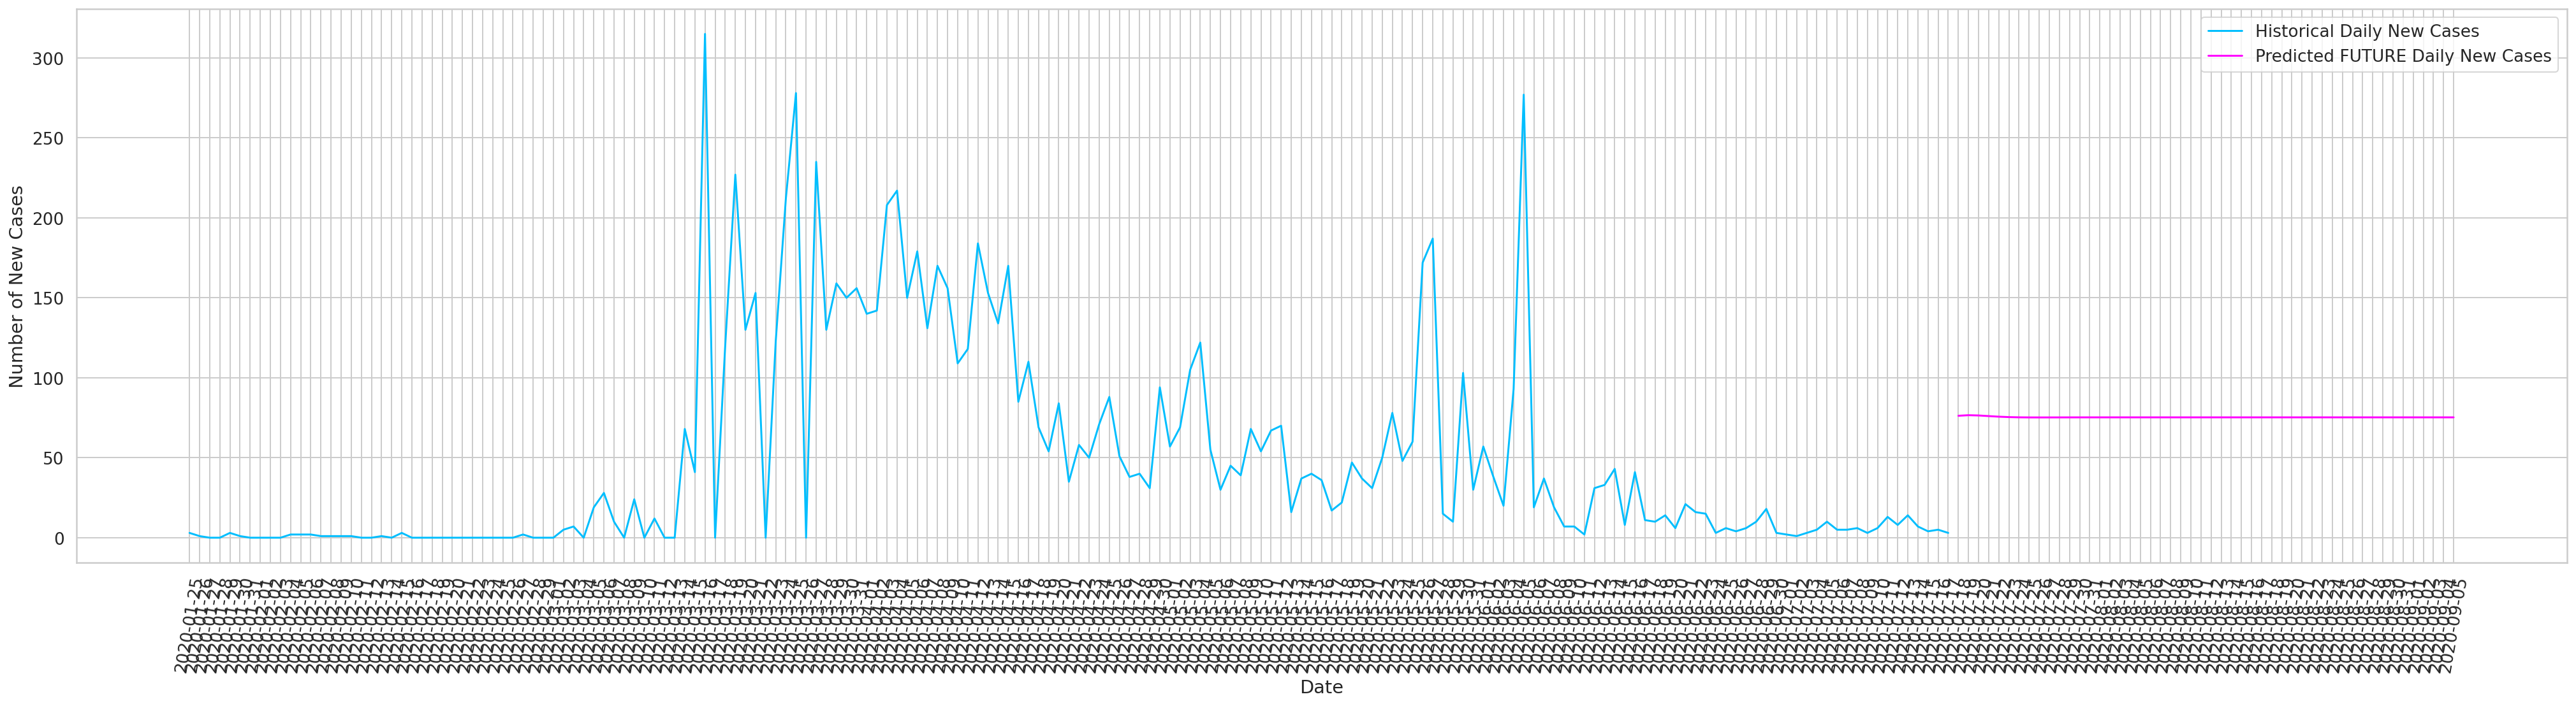

In [ ]:
plt.rcParams["figure.figsize"] = 35, 8
# plt.rcParams['axes.labelpad'] = 20.0
# plt.rcParams['xtick.major.pad']='20'
# plt.axes.Axes.tick_params(width = 20)
# ax = plt.gca()
# ax.tick_params(width=5)
# ax.xaxis.set_tick_params(width=20)

plt.plot(  
  df_Fnew.iloc[: len(FNtrain_data), 0],
  scaler.inverse_transform(FNtrain_data).flatten(),
  label='Historical Daily New Cases'
  
)
# plt.plot(
#   df_new.iloc[len(FNtrain_data):len(FNtrain_data) + len(true_cases3), 0],
#   true_cases3,
#   label='Real Daily New Cases'
# )
plt.plot(
  df_Fnew.iloc[len(FNtrain_data):len(FNtrain_data) + len(predicted_cases3), 0],
  predicted_cases3,
  label='Predicted FUTURE Daily New Cases',
  color='magenta'
)
plt.xlabel('Date')
plt.ylabel('Number of New Cases')
plt.xticks(rotation=80)
plt.legend()

Use all data to be inputed into the model to preduct future DEATH case

In [ ]:
# Add rows for future predictions
# future_day = 50

idx = list(df_death.index)
new_rows = list(map(str, range(4, 4 + future_day)))  # easier extensible than new_rows = ["4", "5"]
idx.extend(new_rows)
df_Fdeath = df_death.reindex(index=idx)

In [ ]:
df_Fdeath = df_Fdeath.reset_index()
df_Fdeath = df_Fdeath.iloc[:, [1, 2]]

In [ ]:
# from datetime import timedelta as td
# import datetime
# import math

# dur = td(days = 1)

for n in range(len(df_Fdeath) - len(df_death)):
  # if math.isnan(df_Fnew.at[n + len(df_new), 'Date_reported']):
    tempDateTime = pd.to_datetime(df_Fdeath.at[n + len(df_death) - 1, 'Date_reported']) + dur
    df_Fdeath.at[n + len(df_death), 'Date_reported'] = datetime.datetime.strftime(tempDateTime,'%Y-%m-%d')

In [ ]:
# data_size = df_malaysia.shape[0]
# test_data_size = int(data_size * 0.20) # Use 25% per test and 80% for train

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Death case train & test data
FDtrain_data = df_death
FDtest_data = df_Fdeath[len(df_death):]

In [ ]:
# FDtest_data

In [ ]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(FDtrain_data.iloc[:, 1], axis = 1))

FDtrain_data = scaler.transform(np.expand_dims(FDtrain_data.iloc[:, 1], axis = 1))
FDtest_data = scaler.transform(np.expand_dims(FDtest_data.iloc[:, 1], axis = 1))

In [ ]:
# seq_length = 30
X_train4, y_train4 = create_sequences(FDtrain_data, seq_length)
X_test4, y_test4 = create_sequences(FDtest_data, seq_length)

X_train4 = torch.from_numpy(X_train4).float()
y_train4 = torch.from_numpy(y_train4).float()

X_test4 = X_train4[:future_day]
y_test4 = y_train4[:future_day]

In [ ]:
model4 = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)

model4, train_hist, test_hist = train_model(
  model4,
  X_train4,
  y_train4,
  X_test4,
  y_test4
)

Epoch 0 train loss: 13.39185905456543 test loss: 0.008954234421253204
Epoch 10 train loss: 6.091117858886719 test loss: 0.10870294272899628
Epoch 20 train loss: 5.785179138183594 test loss: 0.23987075686454773
Epoch 30 train loss: 5.737257957458496 test loss: 0.17624622583389282
Epoch 40 train loss: 5.7232666015625 test loss: 0.18909931182861328
Epoch 50 train loss: 5.709450721740723 test loss: 0.202151358127594
Epoch 60 train loss: 5.695407390594482 test loss: 0.18149685859680176
Epoch 70 train loss: 5.73870325088501 test loss: 0.19920064508914948
Epoch 80 train loss: 5.744178771972656 test loss: 0.19511300325393677
Epoch 90 train loss: 5.728384017944336 test loss: 0.1988016664981842
Epoch 100 train loss: 5.675278186798096 test loss: 0.1996658891439438
Epoch 110 train loss: 5.74057149887085 test loss: 0.19560591876506805
Epoch 120 train loss: 5.737403392791748 test loss: 0.19632866978645325
Epoch 130 train loss: 5.69610071182251 test loss: 0.1946614682674408
Epoch 140 train loss: 5.69

In [ ]:
with torch.no_grad():
  test_seq = X_test4[:1]
  preds = []
  for _ in range(len(X_test4)):
    y_test_pred = model(test_seq)
    pred = torch.flatten(y_test_pred).item()
    preds.append(pred)
    new_seq = test_seq.numpy().flatten()
    new_seq = np.append(new_seq, [pred])
    new_seq = new_seq[1:]
    test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [ ]:
true_cases4 = scaler.inverse_transform(
    np.expand_dims(y_test4.flatten().numpy(), axis=0)
).flatten()
predicted_cases4 = scaler.inverse_transform(
  np.expand_dims(preds, axis=0)
).flatten()

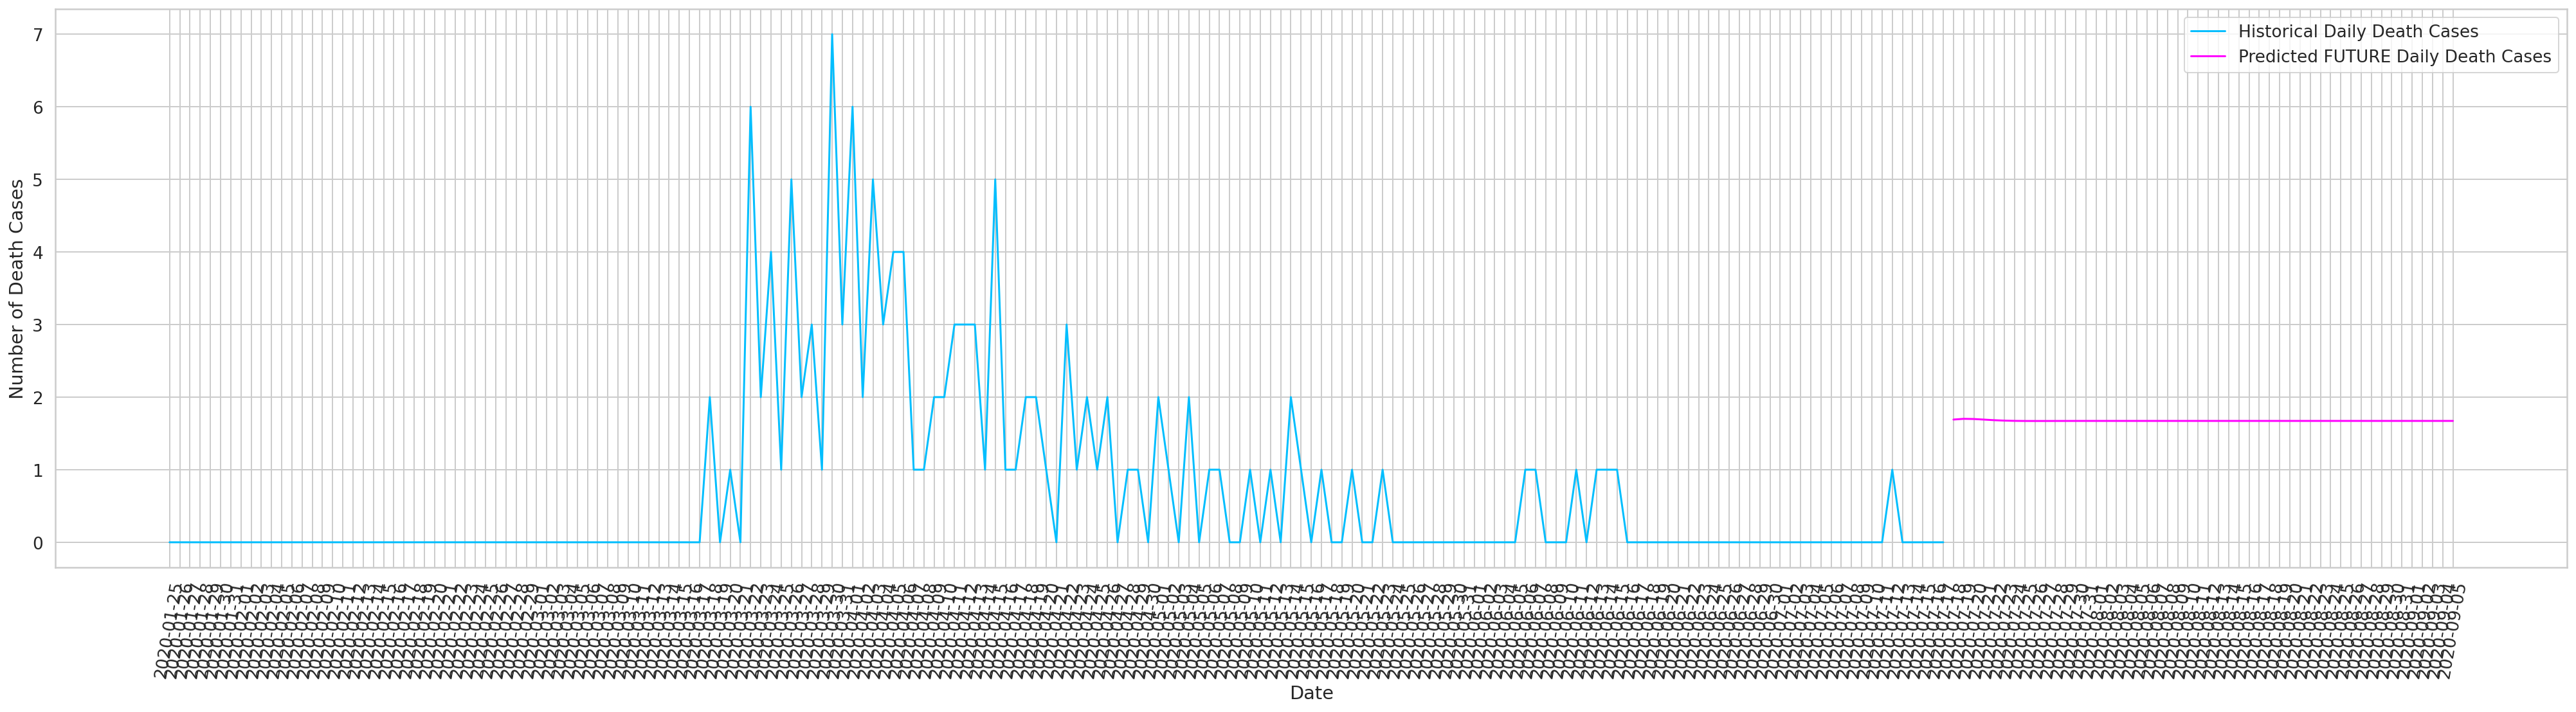

In [ ]:
plt.rcParams["figure.figsize"] = 35, 8

plt.plot(  
  df_Fdeath.iloc[: len(FDtrain_data), 0],
  scaler.inverse_transform(FDtrain_data).flatten(),
  label='Historical Daily Death Cases'
  
)
plt.plot(
  df_Fdeath.iloc[len(FDtrain_data):len(FDtrain_data) + len(predicted_cases4), 0],
  predicted_cases4,
  label='Predicted FUTURE Daily Death Cases',
  color='Magenta'
)
plt.xlabel('Date')
plt.ylabel('Number of Death Cases')
plt.xticks(rotation=80)
plt.legend()

LINEAR REGRESSION - New Case

In [ ]:
df_new_index = df_new.reset_index()
df_new_index.columns

Index(['index', 'Date_reported', ' New_cases'], dtype='object')

In [ ]:
Ntrain_lr = df_new_index[:-test_data_size]
Ntest_lr = df_new_index[-test_data_size:]

In [ ]:
# lin_reg= LinearRegression(normalize=True)
lin_reg= LinearRegression(normalize=True)

lin_reg.fit(np.array(Ntrain_lr["index"]).reshape(-1,1), np.array(Ntrain_lr[" New_cases"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
future_day = len(Ntest_lr)

# new_date=[]
new_prediction_lr=[]
# new_prediction_svm=[]
for i in range(future_day):
  # new_date.append(datewise_malaysia.index[-1]+timedelta(days=i))
  new_prediction_lr.append(int(lin_reg.predict(np.array(df_new_index["index"].max()+i).reshape(-1,1))[0][0]))
  # new_prediction_svm.append(svm.predict(np.array(datewise_malaysia["Days Since"].max()+i).reshape(-1,1))[0])

# pd.set_option("display.float_format",lambda x: '%.f' % x)
# model_prediction=pd.DataFrame(zip(np.array(Ntest_data.iloc[:, 2]), new_prediction_lr),columns=["Actual", "LR_prediction"])
# model_prediction.head(10)

# new_prediction_lr

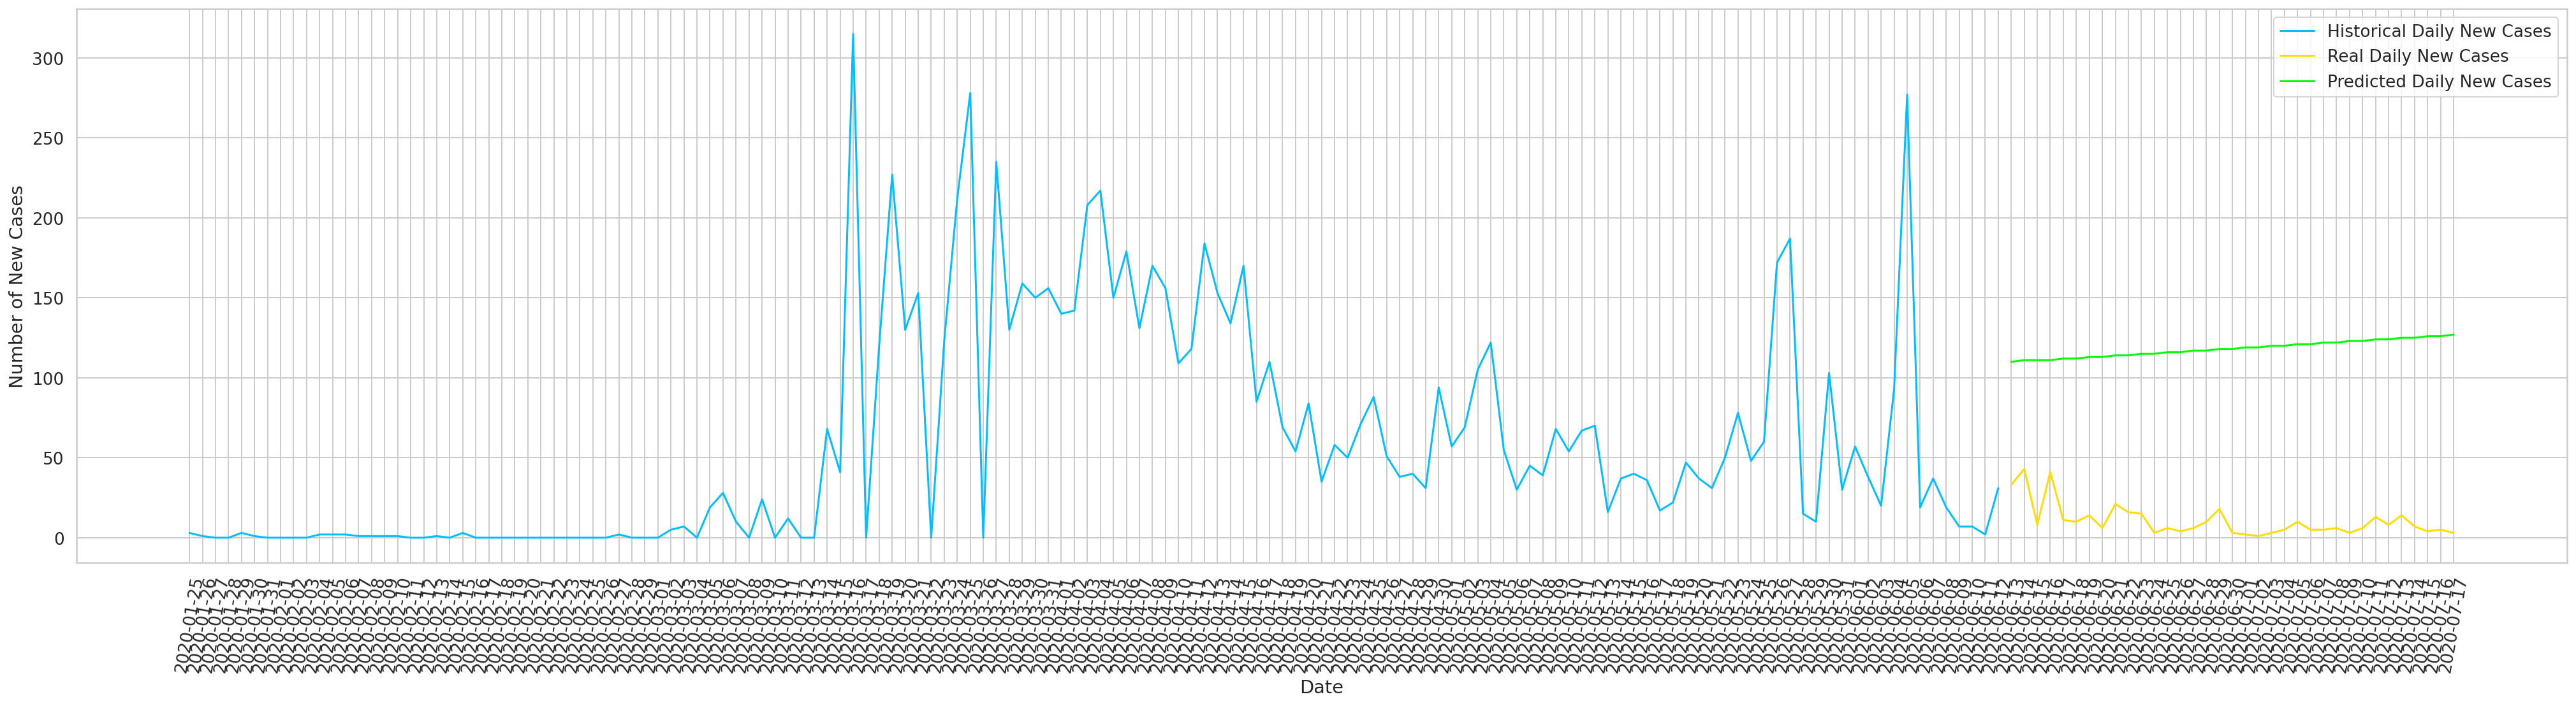

In [ ]:
plt.rcParams["figure.figsize"] = 35, 8

plt.plot(  
  df_new_index.iloc[: len(Ntrain_lr), 1],
  # scaler.inverse_transform(Ntrain_data).flatten(),
  np.array(Ntrain_lr.iloc[: len(Ntrain_lr), 2]),
  label='Historical Daily New Cases'
)

plt.plot(
  df_new_index.iloc[len(Ntrain_lr):len(Ntrain_lr) + len(Ntest_lr), 1],
  np.array(Ntest_lr.iloc[:, 2]),
  label='Real Daily New Cases'
)
plt.plot(
  df_new_index.iloc[len(Ntrain_lr):len(Ntrain_lr) + len(Ntest_lr), 1],
  new_prediction_lr,
  label='Predicted Daily New Cases',
  color='lime'
)

plt.xlabel('Date')
plt.ylabel('Number of New Cases')
plt.xticks(rotation=80)
plt.legend()

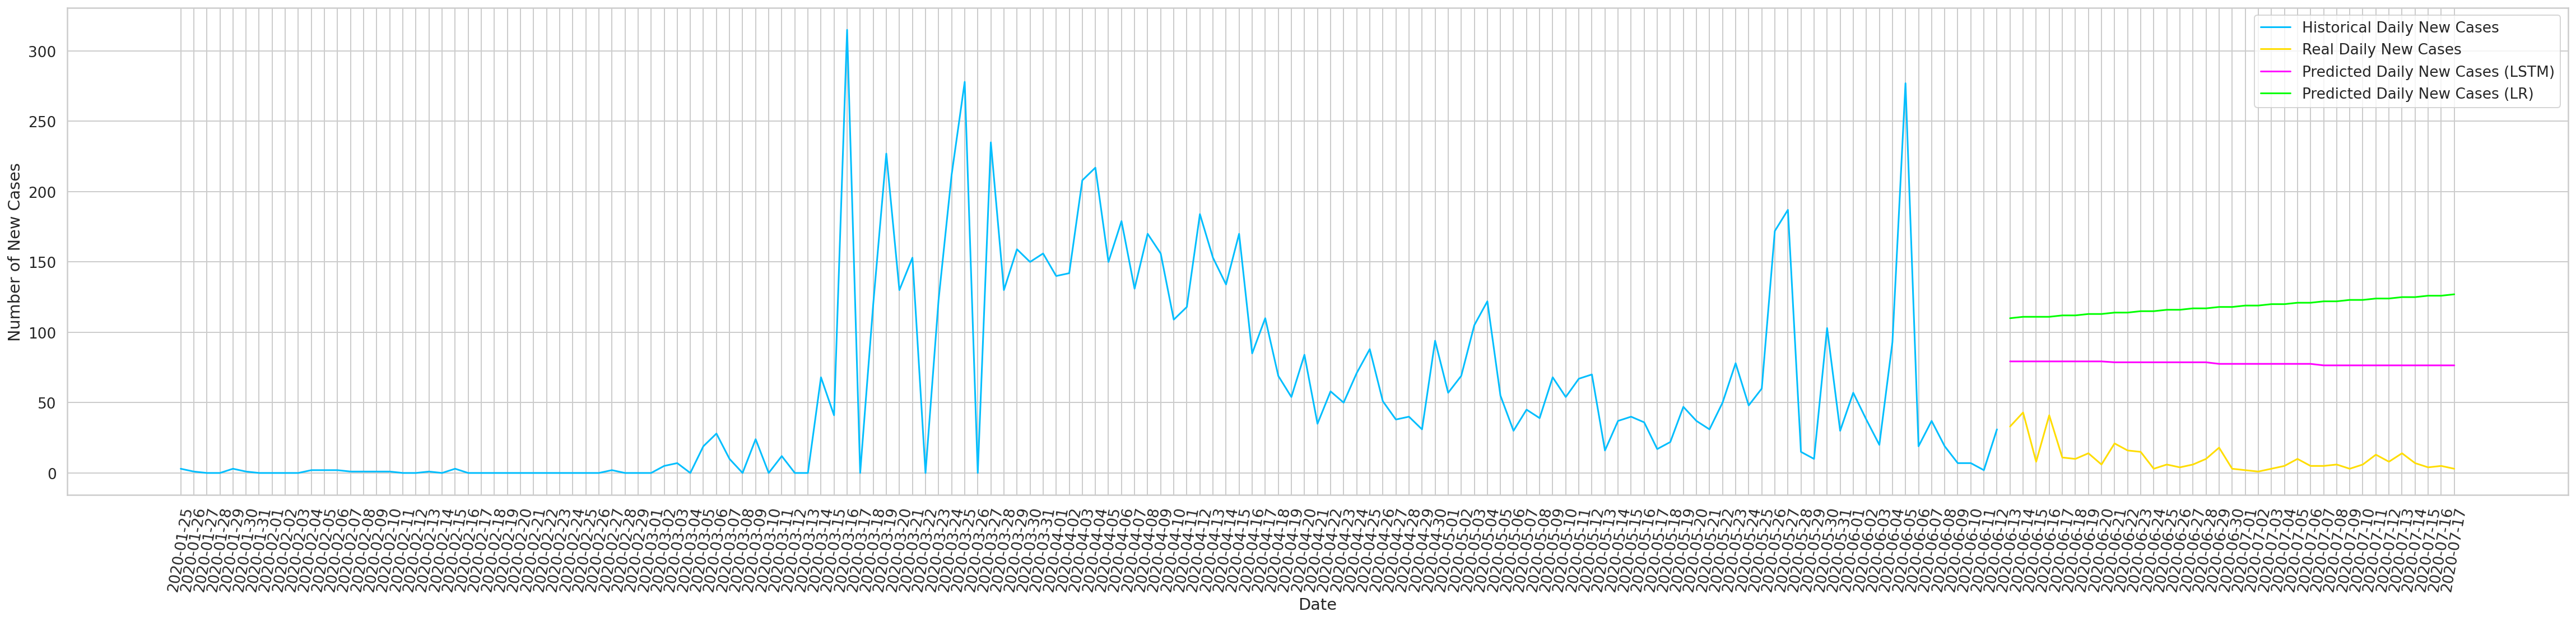

In [ ]:
plt.rcParams["figure.figsize"] = 40, 8

plt.plot(  
  df_new_index.iloc[: len(Ntrain_lr), 1],
  # scaler.inverse_transform(Ntrain_data).flatten(),
  np.array(Ntrain_lr.iloc[: len(Ntrain_lr), 2]),
  label='Historical Daily New Cases'
)

plt.plot(
  df_new_index.iloc[len(Ntrain_lr):len(Ntrain_lr) + len(Ntest_lr), 1],
  # Ntest_data,
  np.array(Ntest_lr.iloc[:, 2]),
  label='Real Daily New Cases'
)
plt.plot(
  df_new.iloc[len(Ntrain_data):len(Ntrain_data) + len(pc), 0],
  # predicted_cases,
  pc,
  label='Predicted Daily New Cases (LSTM)',
  color='Magenta'
)
plt.plot(
  df_new_index.iloc[len(Ntrain_lr):len(Ntrain_lr) + len(Ntest_lr), 1],
  new_prediction_lr,
  label='Predicted Daily New Cases (LR)',
  color='lime'
)

plt.xlabel('Date')
plt.ylabel('Number of New Cases')
plt.xticks(rotation=80)
plt.legend()

In [ ]:
pd.set_option("display.float_format",lambda x: '%.f' % x)
model_prediction=pd.DataFrame(zip(np.array(Ntest_lr.iloc[:, 2]), new_prediction_lr),columns=["Actual", "LR_prediction"])
model_prediction

,Actual,LR_prediction
0,33,110
1,43,111
2,8,111
3,41,111
4,11,112
5,10,112
6,14,113
7,6,113
8,21,114
9,16,114


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(np.array(Ntest_lr.iloc[:, 2]), new_prediction_lr))

print("The RMSE value of new case prediction is =",rmse)  #if less than 180 means ok

The RMSE value of new case prediction is = 108.60334117459607


LINEAR REGRESSION - FUTURE new case

In [ ]:
lin_reg= LinearRegression(normalize=True)
# svm =SVR(C=1, degree=5,kernel='poly',epsilon=0.001)
lin_reg.fit(np.array(df_new_index["index"]).reshape(-1,1),np.array(df_new_index[" New_cases"]).reshape(-1,1))
# svm.fit(np.array(df_new_index["index"]).reshape(-1,1),np.array(df_new_index[" New_cases"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
# prediction_valid_lin_reg = lin_reg.predict(np.array(df_new_index["index"]).reshape(-1,1))

In [ ]:
future_day = 50

# new_date=[]
new_Fprediction_lr=[]
# new_prediction_svm=[]
for i in range(future_day):
  # new_date.append(datewise_malaysia.index[-1]+timedelta(days=i))
  new_Fprediction_lr.append(lin_reg.predict(np.array(df_new_index["index"].max()+i).reshape(-1,1))[0][0])
  # new_prediction_svm.append(svm.predict(np.array(datewise_malaysia["Days Since"].max()+i).reshape(-1,1))[0])

# pd.set_option("display.float_format",lambda x: '%.f' % x)
# model_prediction=pd.DataFrame(new_Fprediction_lr,columns=["LR"])
# model_prediction.head(10)

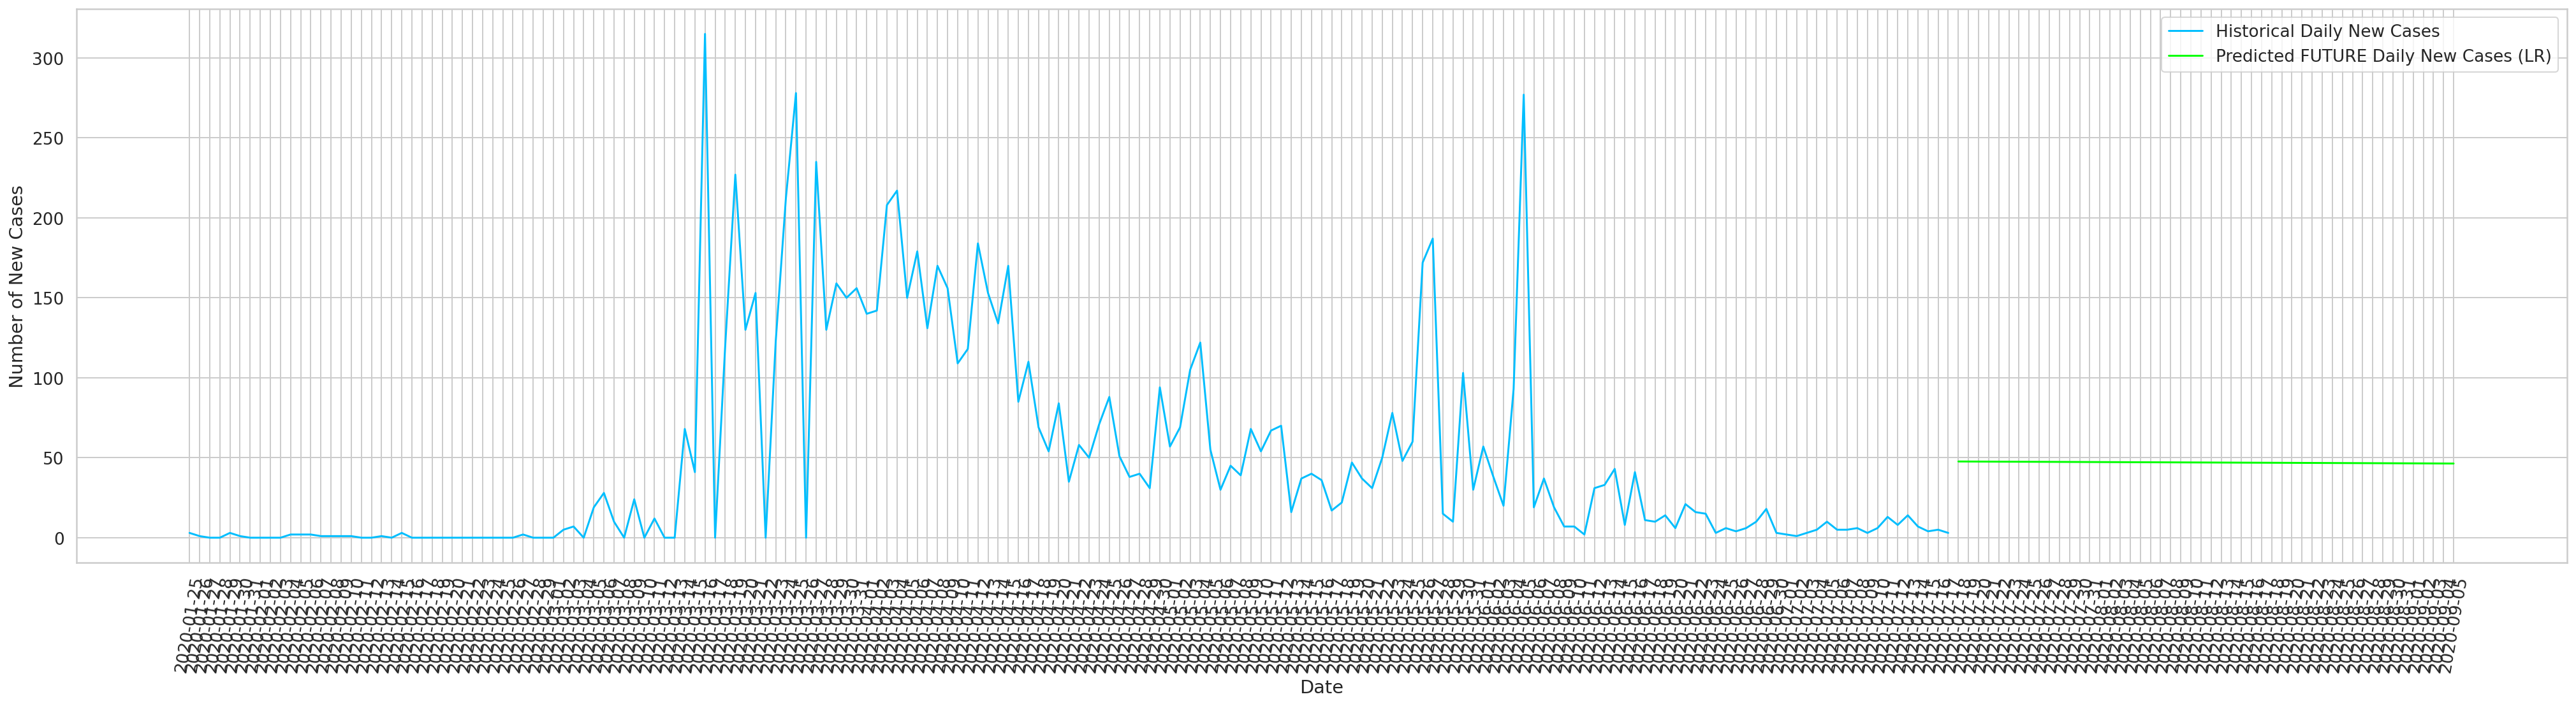

In [ ]:
plt.rcParams["figure.figsize"] = 35, 8

plt.plot(  
  df_new_index.iloc[: len(df_new_index), 1],
  # scaler.inverse_transform(FDtrain_data).flatten(),
  np.array(df_new_index.iloc[: len(df_new_index), 2]),
  label='Historical Daily New Cases'
)
plt.plot(
  df_Fdeath.iloc[len(FDtrain_data):len(FDtrain_data) + len(new_Fprediction_lr), 0],
  new_Fprediction_lr,
  label='Predicted FUTURE Daily New Cases (LR)',
  color = 'lime'
)
plt.xlabel('Date')
plt.ylabel('Number of New Cases')
plt.xticks(rotation=80)
plt.legend()

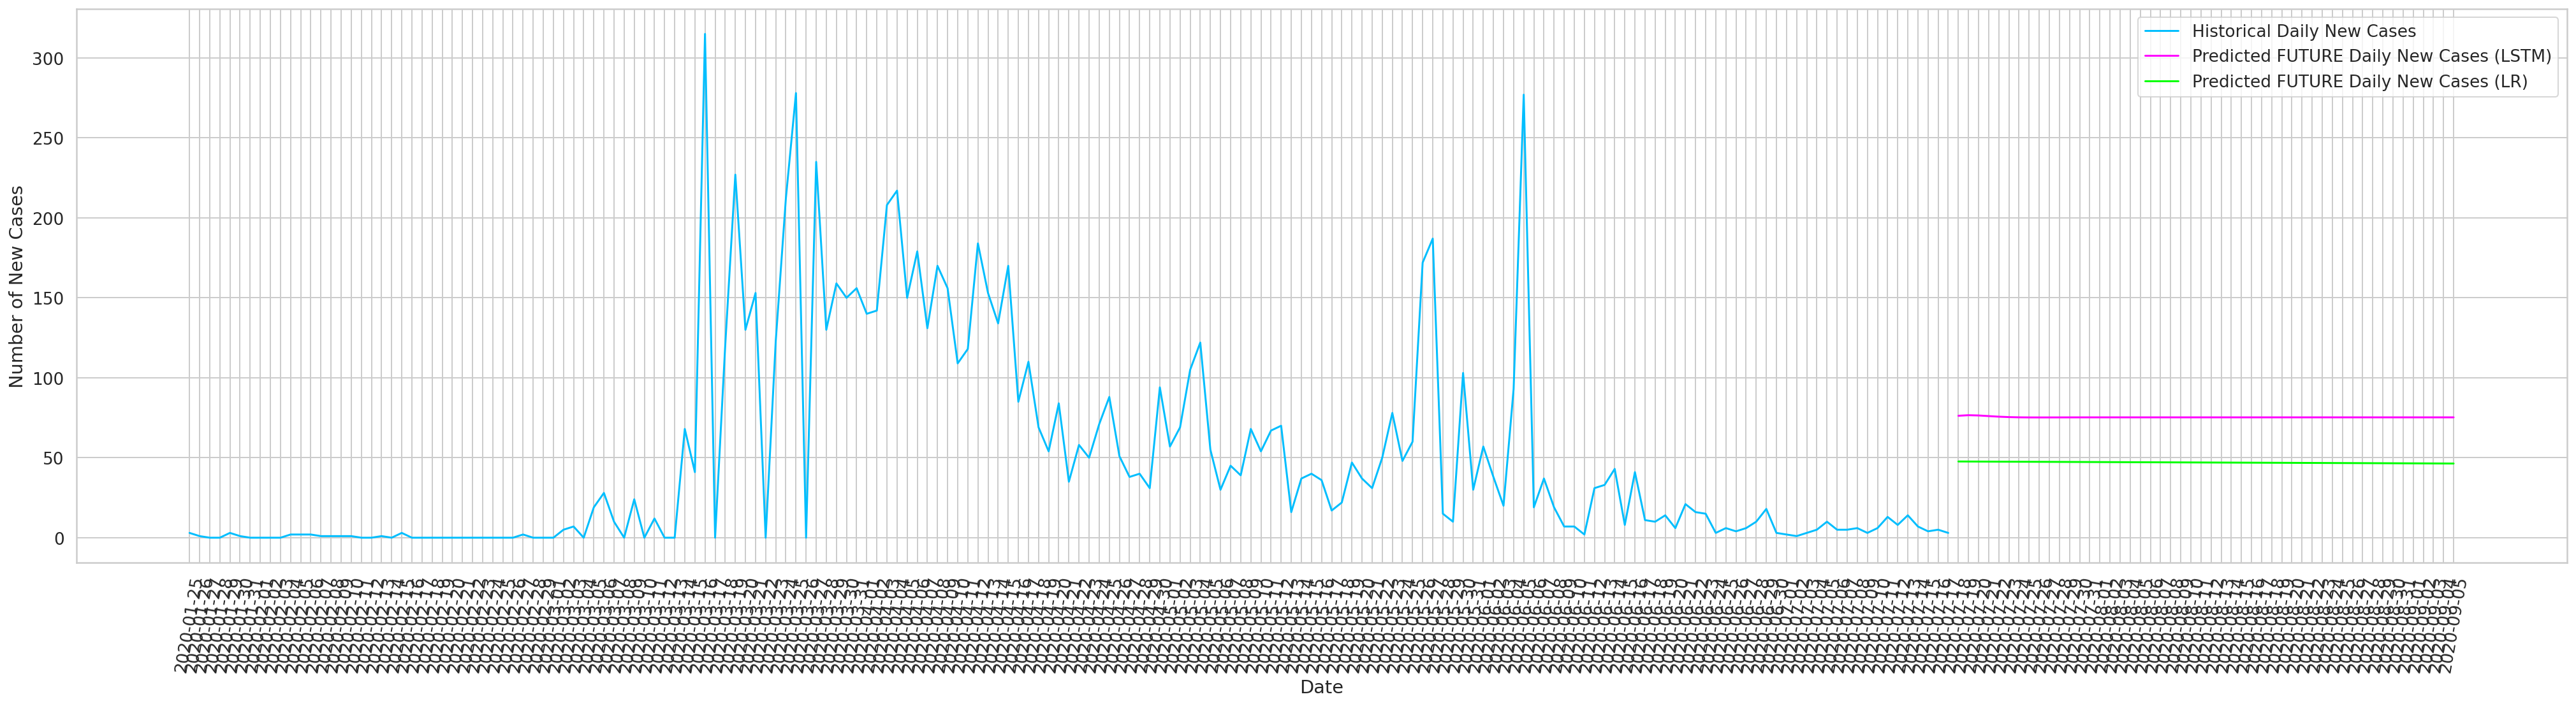

In [ ]:
plt.rcParams["figure.figsize"] = 35, 8

plt.plot(  
  df_new_index.iloc[: len(df_new_index), 1],
  # scaler.inverse_transform(FDtrain_data).flatten(),
  np.array(df_new_index.iloc[: len(df_new_index), 2]),
  label='Historical Daily New Cases'
)
plt.plot(
  df_Fnew.iloc[len(FNtrain_data):len(FNtrain_data) + len(predicted_cases3), 0],
  predicted_cases3,
  label='Predicted FUTURE Daily New Cases (LSTM)',
  color = 'magenta'
)
plt.plot(
  df_Fdeath.iloc[len(FDtrain_data):len(FDtrain_data) + len(new_Fprediction_lr), 0],
  new_Fprediction_lr,
  label='Predicted FUTURE Daily New Cases (LR)',
  color = 'lime'
)
plt.xlabel('Date')
plt.ylabel('Number of New Cases')
plt.xticks(rotation=80)
plt.legend()

LINEAR REGRESSION - Death Case

In [ ]:
df_death_index = df_death.reset_index()
df_death_index.columns

Index(['index', 'Date_reported', ' New_deaths'], dtype='object')

In [ ]:
Dtrain_lr = df_death_index[:-test_data_size]
Dtest_lr = df_death_index[-test_data_size:]

In [ ]:
# lin_reg= LinearRegression(normalize=True)
lin_reg= LinearRegression(normalize=True)

lin_reg.fit(np.array(Dtrain_lr["index"]).reshape(-1,1), np.array(Dtrain_lr[" New_deaths"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
future_day = len(Dtest_lr)

# new_date=[]
death_prediction_lr=[]
# new_prediction_svm=[]
for i in range(future_day):
  # new_date.append(datewise_malaysia.index[-1]+timedelta(days=i))
  death_prediction_lr.append(int(lin_reg.predict(np.array(df_death_index["index"].max()+i).reshape(-1,1))[0][0]))
  # new_prediction_svm.append(svm.predict(np.array(datewise_malaysia["Days Since"].max()+i).reshape(-1,1))[0])

# pd.set_option("display.float_format",lambda x: '%.f' % x)
# model_prediction=pd.DataFrame(zip(np.array(Ntest_data.iloc[:, 2]), new_prediction_lr),columns=["Actual", "LR_prediction"])
# model_prediction.head(10)

# new_prediction_lr

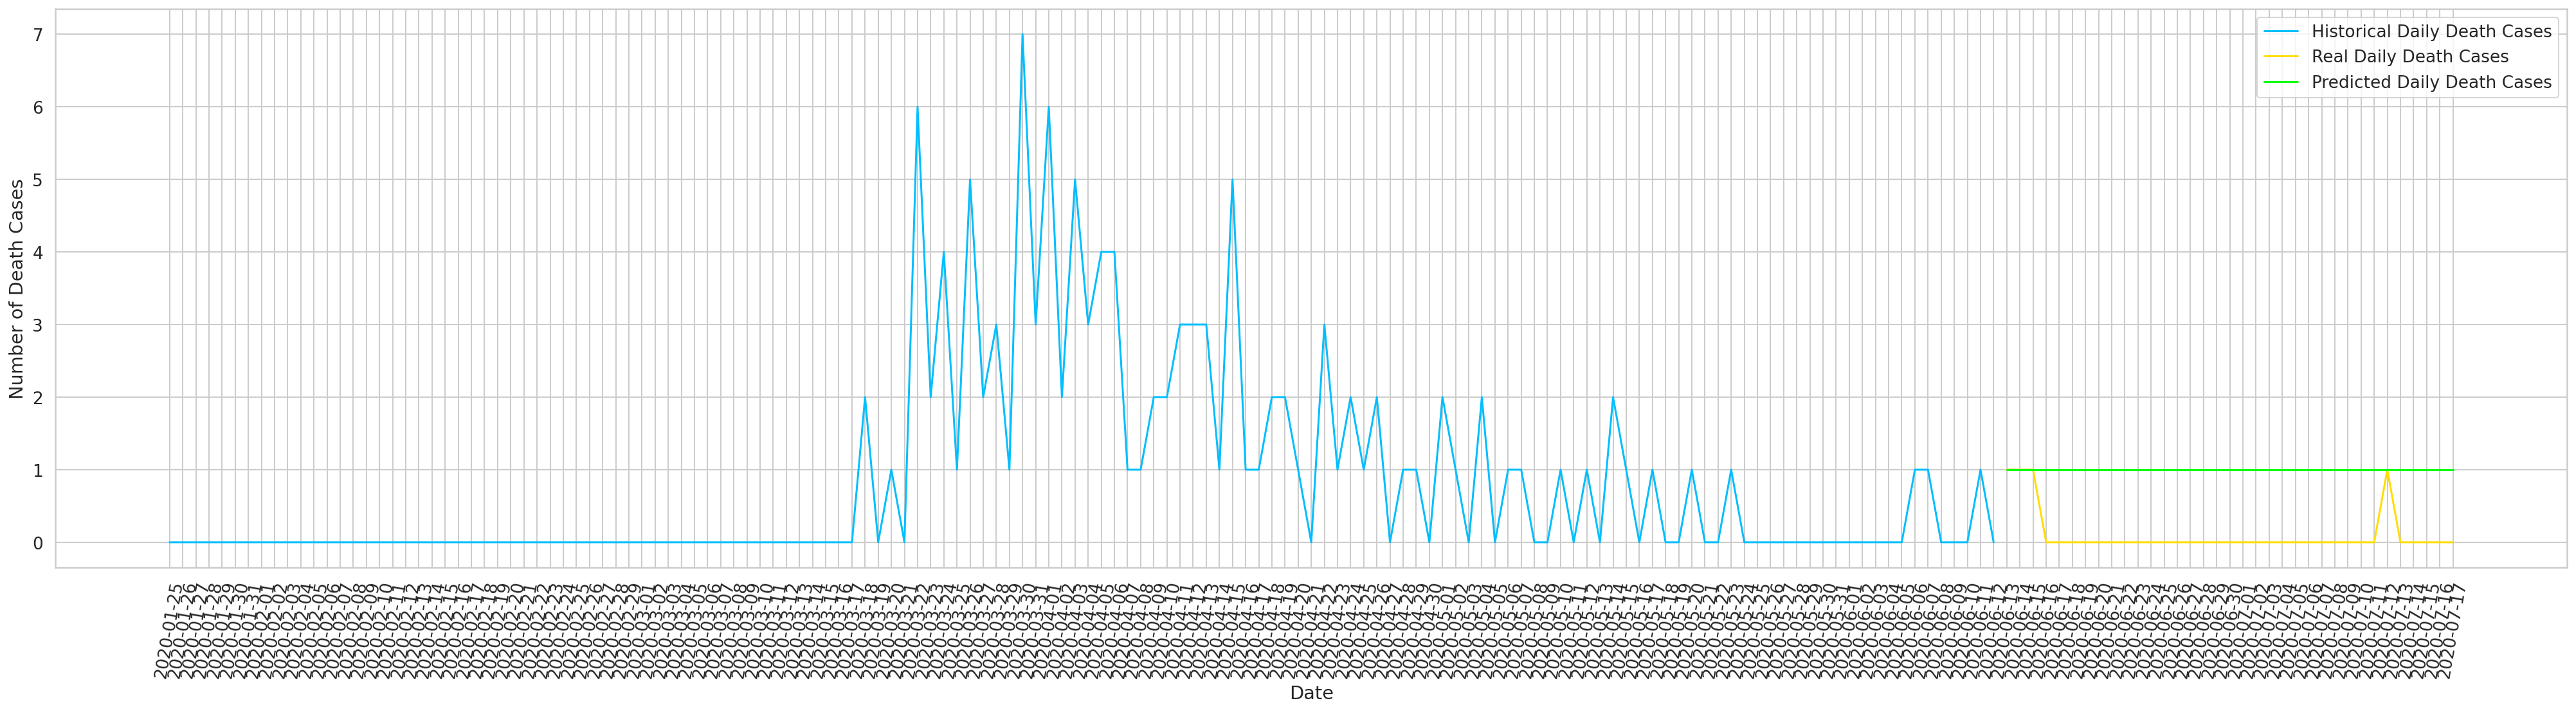

In [ ]:
plt.rcParams["figure.figsize"] = 35, 8

plt.plot(  
  df_death_index.iloc[: len(Dtrain_lr), 1],
  # scaler.inverse_transform(Ntrain_data).flatten(),
  np.array(Dtrain_lr.iloc[: len(Dtrain_lr), 2]),
  label='Historical Daily Death Cases'
)

plt.plot(
  df_death_index.iloc[len(Dtrain_lr):len(Dtrain_lr) + len(Dtest_lr), 1],
  np.array(Dtest_lr.iloc[:, 2]),
  label='Real Daily Death Cases'
)
plt.plot(
  df_death_index.iloc[len(Dtrain_lr):len(Dtrain_lr) + len(Dtest_lr), 1],
  death_prediction_lr,
  label='Predicted Daily Death Cases',
  color='lime'
)

plt.xlabel('Date')
plt.ylabel('Number of Death Cases')
plt.xticks(rotation=80)
plt.legend()

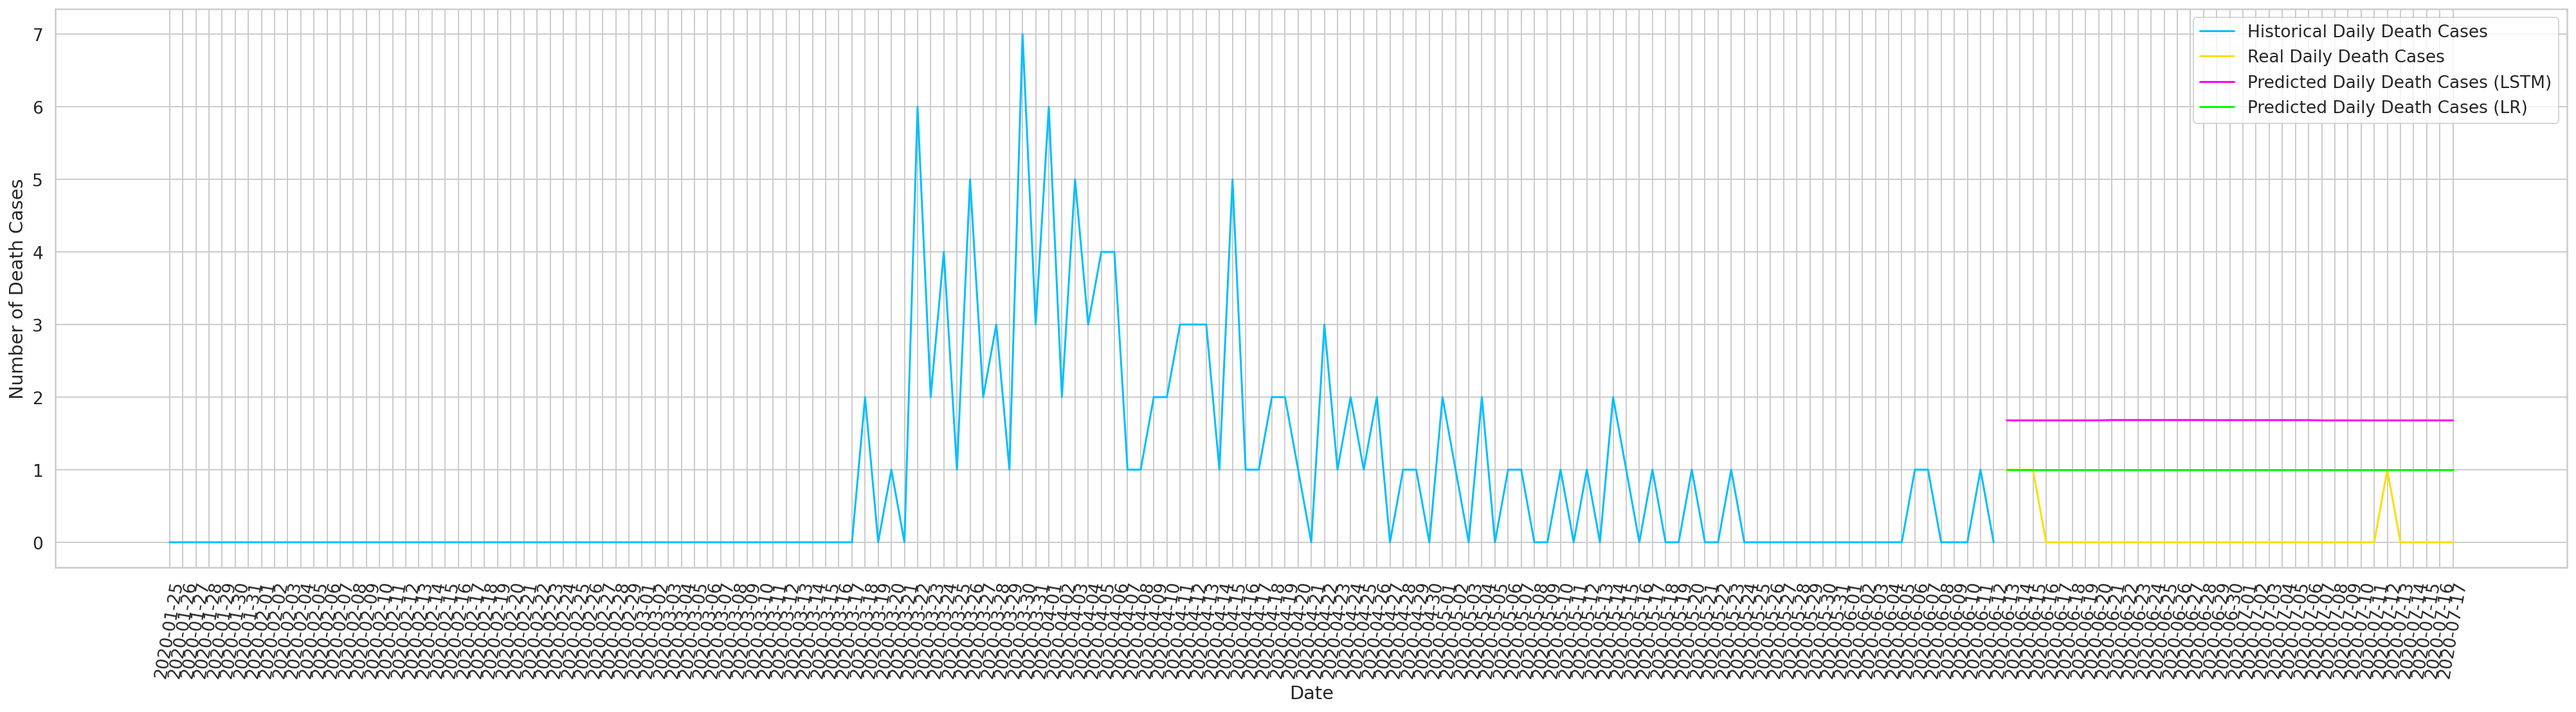

In [ ]:
plt.rcParams["figure.figsize"] = 35, 8

plt.plot(  
  df_death_index.iloc[: len(Dtrain_lr), 1],
  # scaler.inverse_transform(Ntrain_data).flatten(),
  np.array(Dtrain_lr.iloc[: len(Dtrain_lr), 2]),
  label='Historical Daily Death Cases'
)

plt.plot(
  df_death_index.iloc[len(Dtrain_lr):len(Dtrain_lr) + len(Dtest_lr), 1],
  np.array(Dtest_lr.iloc[:, 2]),
  label='Real Daily Death Cases'
)
plt.plot(
  df_death.iloc[len(Dtrain_data):len(Dtrain_data) + len(pc2), 0],
  pc2,
  label='Predicted Daily Death Cases (LSTM)',
  color='magenta'
)
plt.plot(
  df_death_index.iloc[len(Dtrain_lr):len(Dtrain_lr) + len(Dtest_lr), 1],
  death_prediction_lr,
  label='Predicted Daily Death Cases (LR)',
  color='lime'
)

plt.xlabel('Date')
plt.ylabel('Number of Death Cases')
plt.xticks(rotation=80)
plt.legend()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(np.array(Dtest_lr.iloc[:, 2]), death_prediction_lr))

print("The RMSE value of death case prediction is =",rmse)  #if less than 180 means ok

The RMSE value of death case prediction is = 0.9411239481143202


LINEAR REGRESSION - FUTURE Death Case

In [ ]:
# lin_reg= LinearRegression(normalize=True)
lin_reg= LinearRegression(normalize=True)

lin_reg.fit(np.array(Dtrain_lr["index"]).reshape(-1,1), np.array(Dtrain_lr[" New_deaths"]).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
future_day = 50

# new_date=[]
death_Fprediction_lr=[]
# new_prediction_svm=[]
for i in range(future_day):
  # new_date.append(datewise_malaysia.index[-1]+timedelta(days=i))
  death_Fprediction_lr.append(int(lin_reg.predict(np.array(df_death_index["index"].max()+i).reshape(-1,1))[0][0]))
  # new_prediction_svm.append(svm.predict(np.array(datewise_malaysia["Days Since"].max()+i).reshape(-1,1))[0])

# pd.set_option("display.float_format",lambda x: '%.f' % x)
# model_prediction=pd.DataFrame(zip(np.array(Ntest_data.iloc[:, 2]), new_prediction_lr),columns=["Actual", "LR_prediction"])
# model_prediction.head(10)

# new_prediction_lr

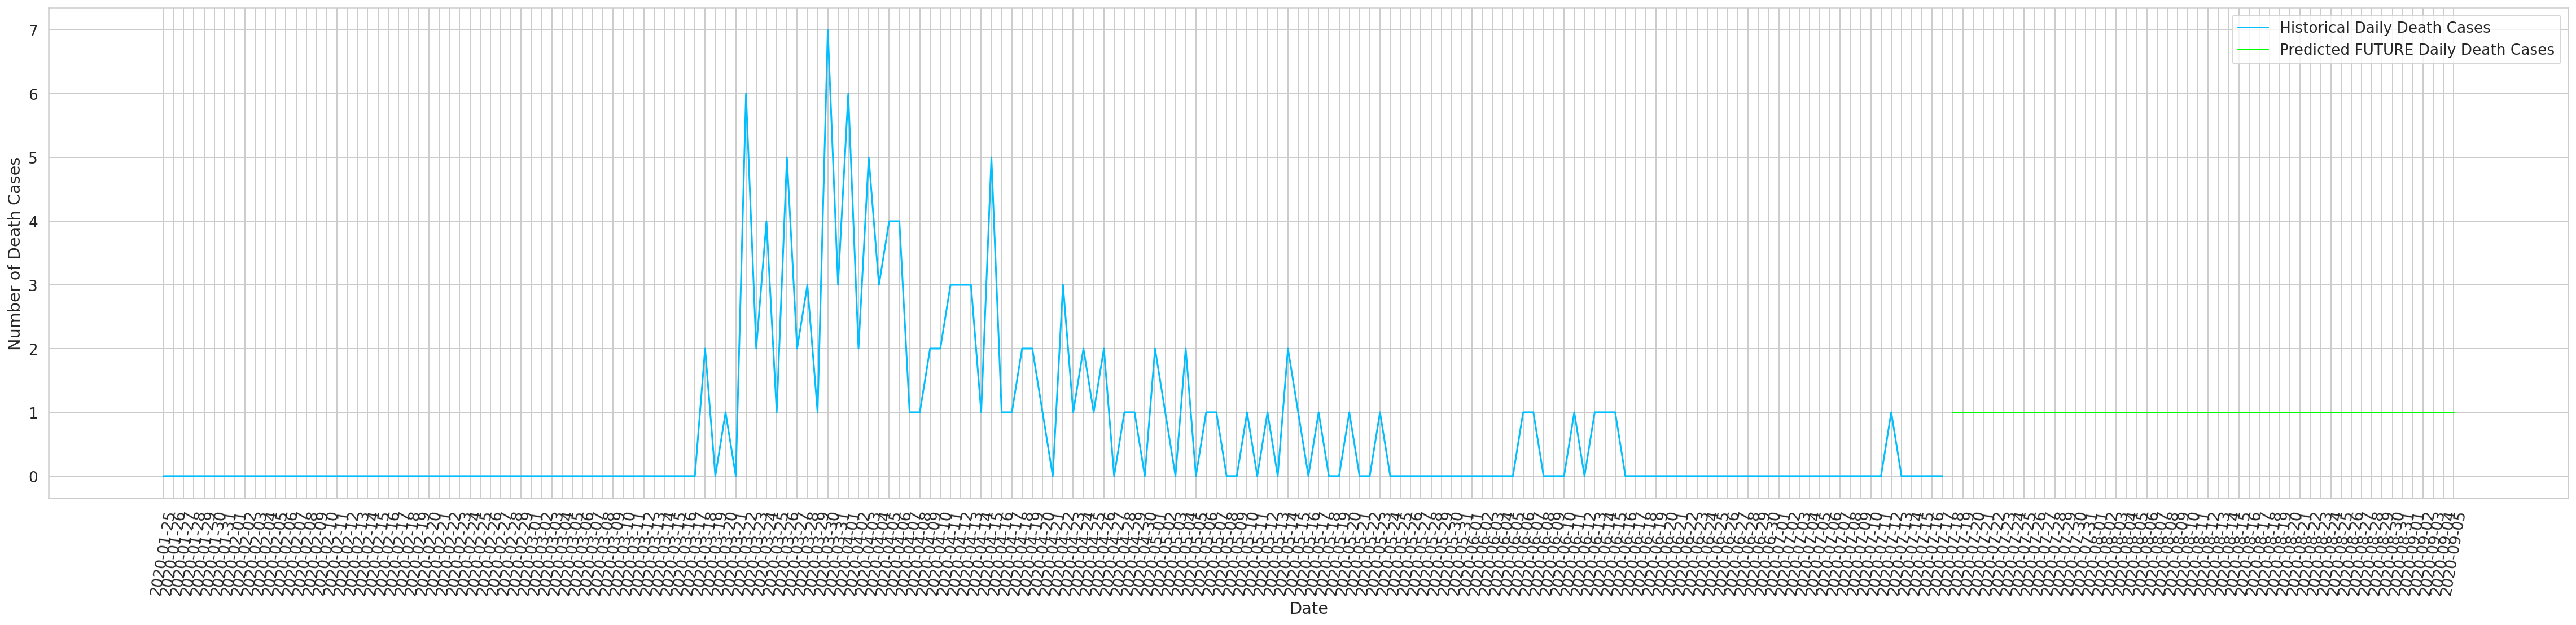

In [ ]:
plt.rcParams["figure.figsize"] = 40, 8

plt.plot(  
  df_death_index.iloc[: len(df_death_index), 1],
  # scaler.inverse_transform(Ntrain_data).flatten(),
  np.array(df_death_index.iloc[: len(df_death_index), 2]),
  label='Historical Daily Death Cases'
)

plt.plot(
  df_Fdeath.iloc[len(FDtrain_data):len(FDtrain_data) + len(new_Fprediction_lr), 0],
  # df_death_index.iloc[len(Dtrain_lr):len(Dtrain_lr) + len(Dtest_lr), 1],
  death_Fprediction_lr,
  label='Predicted FUTURE Daily Death Cases',
  color='lime'
)

plt.xlabel('Date')
plt.ylabel('Number of Death Cases')
plt.xticks(rotation=80)
plt.legend()


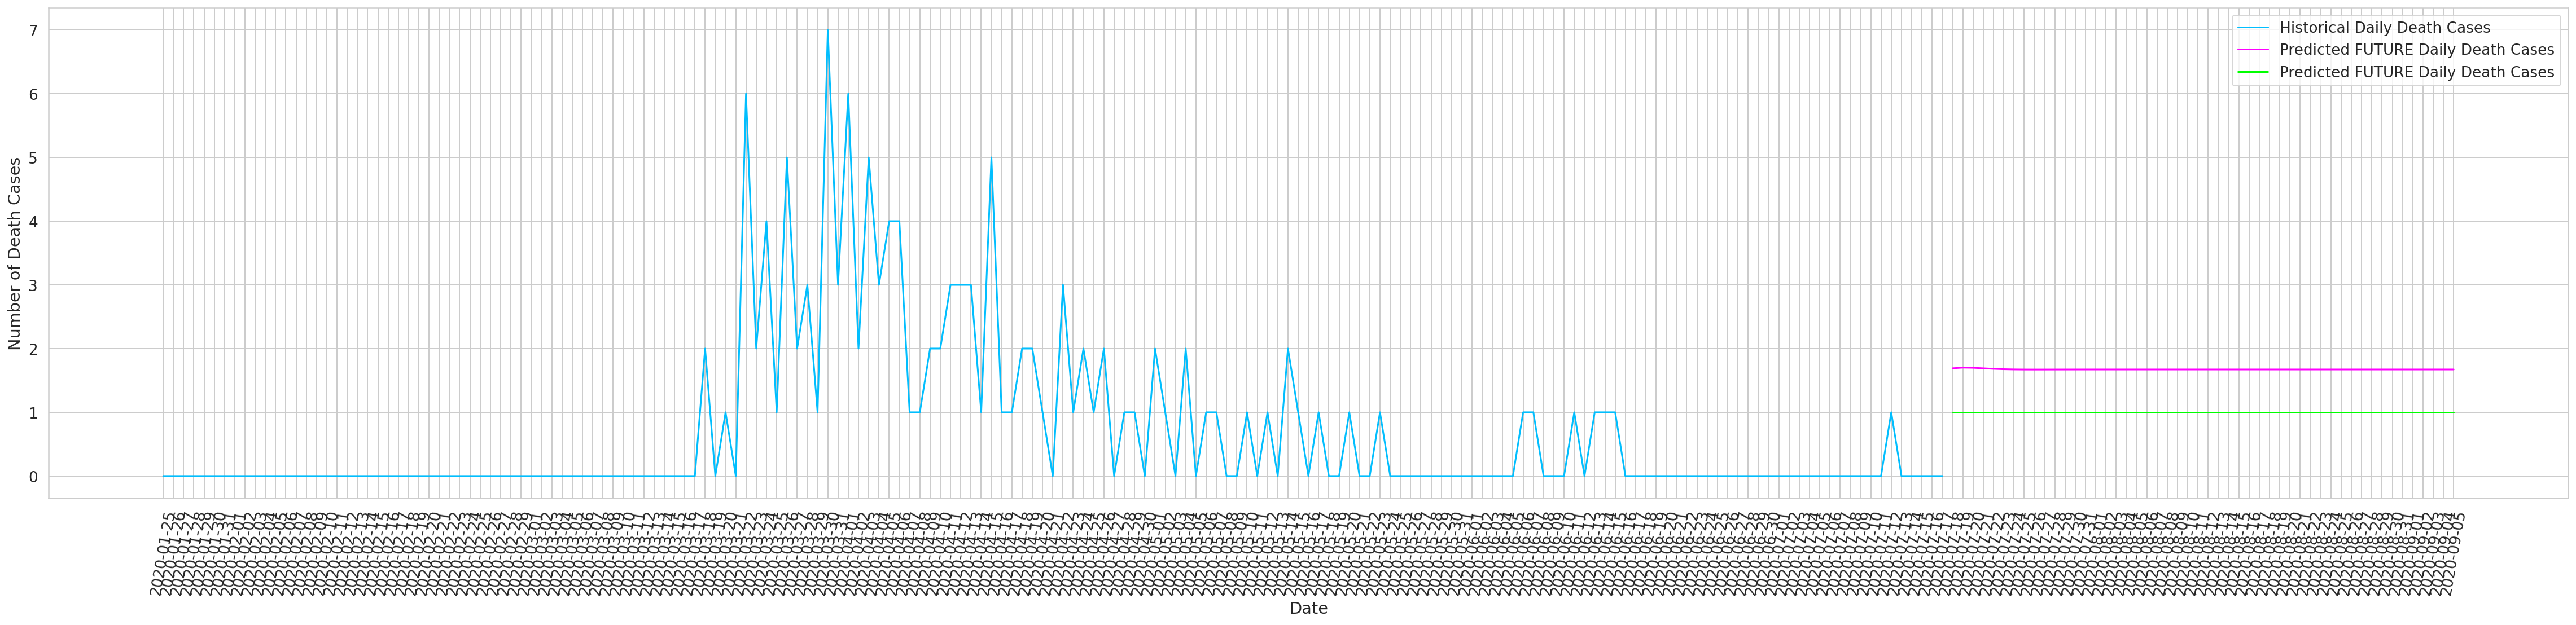

In [ ]:
plt.rcParams["figure.figsize"] = 40, 8

plt.plot(  
  df_death_index.iloc[: len(df_death_index), 1],
  # scaler.inverse_transform(Ntrain_data).flatten(),
  np.array(df_death_index.iloc[: len(df_death_index), 2]),
  label='Historical Daily Death Cases'
)
plt.plot(
  df_Fdeath.iloc[len(FDtrain_data):len(FDtrain_data) + len(predicted_cases4), 0],
  predicted_cases4,
  label='Predicted FUTURE Daily Death Cases',
  color='Magenta'
)

plt.plot(
  df_Fdeath.iloc[len(FDtrain_data):len(FDtrain_data) + len(new_Fprediction_lr), 0],
  # df_death_index.iloc[len(Dtrain_lr):len(Dtrain_lr) + len(Dtest_lr), 1],
  death_Fprediction_lr,
  label='Predicted FUTURE Daily Death Cases',
  color='lime'
)

plt.xlabel('Date')
plt.ylabel('Number of Death Cases')
plt.xticks(rotation=80)
plt.legend()
